# **Product Characteristics Identification** 

<br>

#### With the development of globalization and consumer culture, people from all over the world are buying more and more products through the internet.
#### It is customary on the internet that the buyer shares his or her opinion of the product and the past shopping experience.<br> These reviews have both positive and negative characteristics about the products, this information is valuable because it contributes to internet stores to optimize their services, manufacturers to improve their products and to understand their market needs, and to the consumers themselves by helping them to decide whether to buy a particular product or not.

#### The problem in the data science world that comes up here is, how can a person read all the reviews on a particular product When there are products with thousands of reviews? some of which are long and busy with superficial or irrelevant details. 
<br>


![alt text](infoo.png "Title")

#### We want to find a way to extract the characteristics of a particular product, and product categories in general.
<br>

#### The problem we are facing is an unsupervised problem.<br> Because the dataset we use does not include tagged information about product characteristics, we tried to solve the problem through trial and error, reviewing the data and experiences with various libraries and algorithms.

<br>
_____________________________________________________________________________________________________________________________

### Now let's review some of the ways we used to solve the problem we presented
<br>


#### We will use amazon reviews datasets from  [amazon-reviews-dataset](https://nijianmo.github.io/amazon/index.html), the datasets are categorized by products type.
#### The quality of the dataset is very important for extracting the characteristics properly.
#### We will use two different approaches to solve the problem:<br>First, we will try to solve the problem with word2vec and secondly we will try to solve it using spacy.
#### For each method we use and for each type of category we try, there are some basic repetitive steps:<br>Loading the data, cleaning the data, and separating the data into two parts of positive reviews and negative reviews.
#### In this tutorial we will try to solve the problem using word2vec


<br>
_____________________________________________________________________________________________________________________________

##### First, we start with the imports that are mutual for both approaches

In [1]:
#our import
import os
import json
import gensim
import numpy as np
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import string
import warnings
import pickle
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

#Libraries for cleaning
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import FreqDist
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

#Image load
import requests
from PIL import Image
from io import BytesIO

warnings.filterwarnings('ignore')
%matplotlib inline

INPUT='Cell_Phones_and_Accessories.json.gz'
LIMIT = 2000000

##### For this tutorial, we are using the Cellphones and accessories dataset

In [2]:
#loading the Cell Phones and Accessories dataset 
#Each l represents a CellPhones or Accessories review.
data = []
i = 0
with gzip.open(INPUT) as f:
    for l in f:
        data.append(json.loads(l.strip()))
        i = i+1
        if i == LIMIT:
            break
print('Finished Loading data')     

Finished Loading data


In [3]:
# total length of list, this number equals total number of products
print(len(data))    

2000000


In [4]:
df= pd.DataFrame.from_dict(data)
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,5.0,False,"11 19, 2014",A1GG51FWU0XQYH,098949232X,Paul Williams,If your into space this is the Calendar for you.,Five Stars,1416355200,NaN,NaN,NaN
1,5.0,False,"11 19, 2014",AVFIDS9RK38E0,098949232X,Sean Powell,Awesome pictures!,Five Stars,1416355200,NaN,NaN,NaN
2,5.0,False,"11 19, 2014",A2S4AVR5SJ7KMI,098949232X,Tom Davis,Great wall art and information for space explo...,Five Stars,1416355200,NaN,NaN,NaN
3,5.0,False,"11 19, 2014",AEMMMVOR9BFLI,098949232X,Kwajmeck,"As always, it is a quality calendar full of ve...",I love it. I buy a new one every year,1416355200,NaN,NaN,NaN
4,5.0,False,"11 19, 2014",A2DZXMBTY7KLYP,098949232X,ScottG43,This is a fantastic calendar. This is my third...,Great Calendar.,1416355200,NaN,NaN,NaN


In [5]:
#The columns in the dataset
df.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image', 'style'],
      dtype='object')

##### Cleaning The Data

In [6]:
# remove punctuation 
def remove_punctuation(review): 
    translator = str.maketrans('', '', string.punctuation) 
    return review.translate(translator)

###### We will use the contraction file to turn terms such as "don't" into their formal form, in our example, "don't" will turn to "do not"

In [7]:
#Loading contraction file
contractions = json.load(open("contractions.json"))  

def SplitAndCleanReview(review):

    review=str(review)
    #converting all letters to lower case
    clean_review = review.lower()
    clean_review = clean_review.split()
    new_review = []
    #Replacing the abbreviation with the long phrase
    for word in clean_review:
        if word in contractions:
             new_review.append(contractions[word])
        else:
             new_review.append(word)
    clean_review = " ".join(new_review)
    #removing numbers
    clean_review = re.sub(r'\d+', '', clean_review)
    
    #split review to sentences
    review_sentences=(nltk.tokenize.sent_tokenize(clean_review))
    review_clean_sentences= []
    for i,sent in enumerate(review_sentences):
        if sent==[]:
            continue
        #removing punctuation
        sent = remove_punctuation(sent)
        #removing extra spaces
        sent = re.sub(r' +', ' ', sent)
        review_clean_sentences.append(nltk.word_tokenize(sent))

    
    return review_clean_sentences

In [8]:
#remove 'nan' reviews
df=df[df['reviewText'] != 'nan']
#remove null reviews
df = df.dropna(subset=['reviewText'])
#remove duplicat
df = df.loc[:,~df.columns.duplicated()]
#columns that interests us
df = df[['asin', 'reviewText', 'overall']]

df.head()

,asin,reviewText,overall
0,098949232X,If your into space this is the Calendar for you.,5.0
1,098949232X,Awesome pictures!,5.0
2,098949232X,Great wall art and information for space explo...,5.0
3,098949232X,"As always, it is a quality calendar full of ve...",5.0
4,098949232X,This is a fantastic calendar. This is my third...,5.0


#### As we can see, the number of people who rated 5 is significantly higher than the other options, which means that most buyers are satisfied with their purchase.

Text(0.5, 1.0, 'Distribution of Ratings')

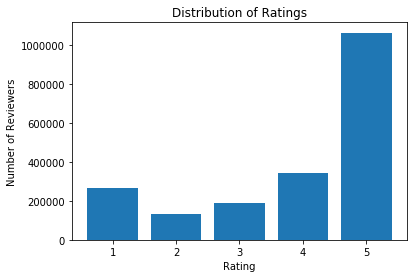

In [9]:
#Rating distribution
df_rating = df.groupby(["overall"])["asin"].count().reset_index(name="count")

x = [rate for rate in df_rating['overall']]
y = [count for count in df_rating['count']]

plt.bar(x,y)
plt.xlabel("Rating")
plt.ylabel("Number of Reviewers")
plt.title("Distribution of Ratings")

##### Separating the data into positive reviews and negative reviews by rating

In [10]:
#Dataset containing reviews with high rate only
df_positive_reviews = df[df.overall > 3]
df_positive_reviews= df_positive_reviews.reset_index()
print("amount of positive reviews: ",df_positive_reviews.shape[0])

amount of positive reviews:  1410282


In [11]:
#Printing positive reviews examples
for i in range(3):
    print(df_positive_reviews["reviewText"][i],'\n')

If your into space this is the Calendar for you. 

Awesome pictures! 

Great wall art and information for space exploration minded people. 



In [12]:
#Dataset containing reviews with low rate only
df_negative_reviews = df[df.overall < 3]
df_negative_reviews= df_negative_reviews.reset_index()
print("amount of negative reviews: ",df_negative_reviews.shape[0])

amount of negative reviews:  401685


In [13]:
#Printing negative reviews examples
for i in range(3):
    print(df_negative_reviews["reviewText"][i],'\n')

Way to much stuff on the pages leaves a small calendar with very fine print. 

Did hot work as described 

The title insinuates that it is a genuine Samsung product but it is not and only worked intermittently and after 3 months ....does not work at all.  Pretty clear why it's so cheap.  Don't fall for it.  I would give it zero stars if I could. 



##### Cleaning and splitting each review to a list of clean sentences

In [14]:
df_positive_reviews['reviewSentences']=df_positive_reviews['reviewText'].apply(SplitAndCleanReview)
df_positive_reviews.head()

,index,asin,reviewText,overall,reviewSentences
0,0,098949232X,If your into space this is the Calendar for you.,5.0,"[[if, your, into, space, this, is, the, calend..."
1,1,098949232X,Awesome pictures!,5.0,"[[awesome, pictures]]"
2,2,098949232X,Great wall art and information for space explo...,5.0,"[[great, wall, art, and, information, for, spa..."
3,3,098949232X,"As always, it is a quality calendar full of ve...",5.0,"[[as, always, it, is, a, quality, calendar, fu..."
4,4,098949232X,This is a fantastic calendar. This is my third...,5.0,"[[this, is, a, fantastic, calendar], [this, is..."


In [15]:
#Printing positive reviews after cleaning examples
for i in range(3):
    print(df_positive_reviews["reviewSentences"][i],'\n')

[['if', 'your', 'into', 'space', 'this', 'is', 'the', 'calendar', 'for', 'you']] 

[['awesome', 'pictures']] 

[['great', 'wall', 'art', 'and', 'information', 'for', 'space', 'exploration', 'minded', 'people']] 



In [16]:
df_negative_reviews['reviewSentences']=df_negative_reviews['reviewText'].apply(SplitAndCleanReview)
df_negative_reviews.head()

,index,asin,reviewText,overall,reviewSentences
0,24,098949232X,Way to much stuff on the pages leaves a small ...,2.0,"[[way, to, much, stuff, on, the, pages, leaves..."
1,179,1060297744,Did hot work as described,1.0,"[[did, hot, work, as, described]]"
2,180,1060297744,The title insinuates that it is a genuine Sams...,1.0,"[[the, title, insinuates, that, it, is, a, gen..."
3,184,1060297744,This does NOT work for the 12.2 tablet I had b...,1.0,"[[this, does, not, work, for, the], [tablet, i..."
4,186,1060297744,Did not work at all on my note 2. Wouldnt reco...,1.0,"[[did, not, work, at, all, on, my, note], [wou..."


In [17]:
#Printing negative reviews after cleaning examples
for i in range(3):
    print(df_negative_reviews["reviewSentences"][i],'\n')

[['way', 'to', 'much', 'stuff', 'on', 'the', 'pages', 'leaves', 'a', 'small', 'calendar', 'with', 'very', 'fine', 'print']] 

[['did', 'hot', 'work', 'as', 'described']] 

[['the', 'title', 'insinuates', 'that', 'it', 'is', 'a', 'genuine', 'samsung', 'product', 'but', 'it', 'is', 'not', 'and', 'only', 'worked', 'intermittently', 'and', 'after', 'months', 'does', 'not', 'work', 'at', 'all'], ['pretty', 'clear', 'why', 'it', 'is', 'so', 'cheap'], ['do', 'not', 'fall', 'for', 'it'], ['i', 'would', 'give', 'it', 'zero', 'stars', 'if', 'i', 'could']] 



<br>
_____________________________________________________________________________________________________________________________

### So what is Word2Vec?
<br>

#### **Word2vec** is a group of related models that are used to produce word embeddings. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words. Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space. Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located close to one another in the space

#### The idea behind Word2Vec is pretty simple. We’re making an assumption that the meaning of a word can be inferred by the company it keeps. This is analogous to the saying, “show me your friends, and I’ll tell who you are”.

#### If we have two words that have very similar neighbors (meaning: the context in which it’s used is about the same), then these words are probably quite similar in meaning or are at least related. For example, the words "good", "great" and "bad" are usually used in a similar context.

###### for more information: [Documentation](https://radimrehurek.com/gensim/models/word2vec.html) , [Word2vec Tutorial](https://rare-technologies.com/word2vec-tutorial/)
#### Word2Vec builds a vector for each word by identifying words with a similar meaning in the sentence.<br>Our goal is to identify the nouns that appear in reviews so that we can extract the characteristics of a particular product and of product categories in general.

<br>

##### word2vec approach imports

In [18]:
import itertools
from gensim.models import Word2Vec
from collections import defaultdict
from sklearn.cluster import KMeans

#### We chose to build two word2vec models, One for the positive reviews and one for the negative reviews, because this line of thought and the distribution we got gave us the best results from the attempts we made.
#### In the initial stage, we'll initialize each model with the appropriate 'reviewsSentences' column we created on the cleaning stage, through which the model will learn the relationships between the words.<br> So, we essentially initialized each model with a list of lists, where each list within the main list contains a set of tokens from each sentence that in each review. <br>Word2Vec uses all these tokens to create a vocabulary of unique words.



##### Training the Word2Vec models

In [19]:
class MySentences(object):

    def __init__(self, df):
        self.df = df
        
    def __iter__(self):
        for review_sent in self.df['reviewSentences']:
            for sent in review_sent:
                yield sent

In [20]:
#word2vec for positive sentences

# build vocabulary and train model
positive_sentences = MySentences(df_positive_reviews) 
# workers= how many threads to use behind the scenes.
positive_model_word2vec = gensim.models.Word2Vec(positive_sentences, workers=10, iter=10)

In [21]:
#word2vec for negative sentences

# build vocabulary and train model
negative_sentences = MySentences(df_negative_reviews) 
# workers= how many threads to use behind the scenes.
negative_model_word2vec = gensim.models.Word2Vec(negative_sentences,  workers=10, iter=10)

In [22]:
#KeyedVectors for each positive reviews and negative reviews separately
KeyedVectors_positive = positive_model_word2vec.wv

KeyedVectors_negative = negative_model_word2vec.wv

In [23]:
#save all the positve and negative words that extracted from word2vec
positive_words= list((KeyedVectors_positive.vocab).keys())
with open('Cellphones/word2vec/cellphone_word2vec_positive_words.txt',mode='w') as f:
            json.dump(positive_words, f)
        
negative_words= list((KeyedVectors_negative.vocab).keys())
with open('Cellphones/word2vec/cellphone_word2vec_negative_words.txt',mode='w') as f:
            json.dump(negative_words, f)

In [24]:
#save all the positve and negative vectors that extracted from word2vec
positive_vectors= [KeyedVectors_positive.word_vec(word) for word in positive_words]
np.save("Cellphones/word2vec/cellphone_word2vec_positive_vectors.npy",positive_vectors)

negative_vectors= [KeyedVectors_negative.word_vec(word) for word in negative_words]
np.save("Cellphones/word2vec/cellphone_word2vec_negative_vectors.npy",negative_vectors)

In [25]:
#amount of unique words in positive reviews
len(positive_words)

45292

In [26]:
#amount of unique words in negative reviews
len(negative_vectors)

24520

In [27]:
#read positive and negative words and their vectors
positive_words=[]
with open('Cellphones/word2vec/cellphone_word2vec_positive_words.txt',mode='r') as f:
            positive_words = json.load(f)
        
positive_vectors =np.load("Cellphones/word2vec/cellphone_word2vec_positive_vectors.npy")


negative_words=[]
with open('Cellphones/word2vec/cellphone_word2vec_negative_words.txt',mode='r') as f:
            negative_words = json.load(f)
        
negative_vectors =np.load("Cellphones/word2vec/cellphone_word2vec_negative_vectors.npy")

In [28]:
#Function to visualize W2V head-100 words
def w2v_visualize(vectors, words):    
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(vectors[:100,:])
    plt.scatter(Y[:, 0], Y[:, 1])
    for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.show()

#### As we can see from the first 100 positive words, the model gave us some good results such as "space" and "room" or "nice", "great", "beautiful" and "awesome".

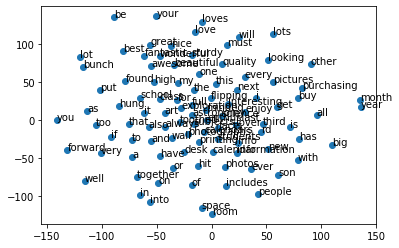

In [29]:
#Visualizing the head-100 positive words in W2V model
w2v_visualize(positive_model_word2vec[positive_model_word2vec.wv.vocab], positive_model_word2vec.wv.vocab)

#### Here as well, we got some good results such as "could" and "would" or "samsung" and "iphone".

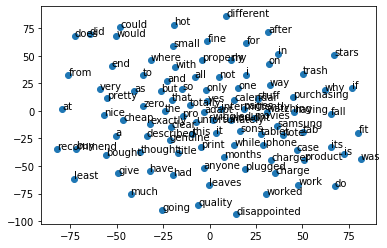

In [30]:
#Visualizing the head-100 negative words in W2V model
w2v_visualize(negative_model_word2vec[negative_model_word2vec.wv.vocab], negative_model_word2vec.wv.vocab)

<br>
_____________________________________________________________________________________________________________________________

#### After we run word2vec and extract  the unique words and vectors, We run the vectors on K-means algorithm because of it's ability to handle large amounts of data and its relatively fast loading.
#### K-means algorithm will help us classify the words into groups according to the proximity of their vectors.<br> We chose to classify the words into 7 groups (7 centroids) due to the naive expectation of division into Parts of Speech:<br>noun, pronoun, adjective, verb, adverb, preposition, Conjunctions.
#### Here, again, we separated the vectors of the positive reviews from the negatives and run K-means algorithm on each set of vectors separately.

##### K-means Clustering

In [31]:
def someValues(max,group):
    
    for i in range(0,max,1):
        if len(group)<=i:
            print("\nNo More Words In This Group")
            break
        else:
            print(group[i])

In [32]:
#Function that prints 20-head words from each centroid of k-means
def WordsFromEachCluster(words_lst, model, num_print):
    
    words_in_clusters = defaultdict(list)

    for i,word in enumerate(words_lst):
        pred=model.labels_[i]
        words_in_clusters[pred].append(word)   

    keys_list= list(words_in_clusters.keys())
    
    for i in sorted(keys_list):
        print("GROUP ",i)
        someValues(num_print,words_in_clusters[i])
        print("\n\n")

In [33]:
#Function to visualize k-means clusters
def kmeans_visualize(kmeans, vectors):
    pca = PCA(n_components=2)
    x_pca = pca.fit(vectors).transform(vectors)
    y_kmeans = kmeans.fit_predict(vectors)

    plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y_kmeans, marker="o", cmap='magma')

In [34]:
#k-means clustring for positive reviews

kmeans_positive = KMeans(n_clusters=7, random_state=500).fit(positive_vectors)
WordsFromEachCluster(positive_words,kmeans_positive,20)

GROUP  0
if
into
this
is
for
great
and
exploration
minded
as
always
a
very
every
well
has
in
forward
to
toothed



GROUP  1
your
buy
put
get
be
enjoy
have
hit
use
recommend
anyone
make
are
learn
spend
afford
believe
hide
act
go



GROUP  2
wall
i
year
my
bunch
next
month
desk
son
or
hung
school
room
students
lot
getting
day
moon
sky
something



GROUP  3
calendar
art
quality
full
new
one
rd
science
photographs
calendars
class
other
printing
box
page
addition
everything
history
monthly
guides



GROUP  4
awesome
interesting
love
fantastic
third
purchasing
will
looking
loves
wonderful
best
found
big
must
lover
useful
delivered
buying
done
filled



GROUP  5
space
the
it
of
sturdy
together
flipping
too
nice
which
flat
easy
there
squares
viewing
thing
shows
back
way
place



GROUP  6
you
pictures
information
people
photos
info
facts
images
detail
years
purchases
indicators
we
activities
times
things
stuff
they
them
graphics





#### Each color represents a cluster, as we can see, three of the clusters are denser and homogenous than the others.

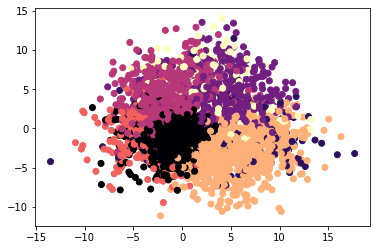

In [35]:
#Visualizing positive k-means clusters
kmeans_visualize(kmeans_positive, positive_vectors)

In [36]:
#k-means clustring for negative reviews

kmeans_negative = KMeans(n_clusters=7, random_state=500).fit(negative_vectors)

WordsFromEachCluster(negative_words,kmeans_negative,20)

GROUP  0
a
with
very
did
as
that
is
but
not
only
after
at
all
pretty
so
do
for
would
zero
if



GROUP  1
way
stuff
on
the
print
it
and
end
tab
where
case
iphone
properly
too
phone
looks
protective
off
creates
around



GROUP  2
title
genuine
samsung
product
months
why
i
stars
this
bought
one
note
least
purchasing
pro
trash
going
sons
we
difference



GROUP  3
work
give
recommend
anyone
buy
have
charge
fit
tighten
know
return
make
use
feel
be
take
get
want
try
see



GROUP  4
leaves
worked
fall
had
having
plugged
moved
blocks
got
cuts
used
making
went
kept
cutting
sitting
loses
came
bent
using



GROUP  5
much
small
fine
hot
described
does
clear
cheap
different
disappointed
nice
quality
well
likely
can
better
quick
great
love
amazing



GROUP  6
to
pages
calendar
intermittently
tablet
charger
while
watching
movies
attempts
sense
cell
signal
calls
or
wifi
ipod
call
bars
everything





#### Here as well, three of the clusters are more dense and homogeneous than the others.

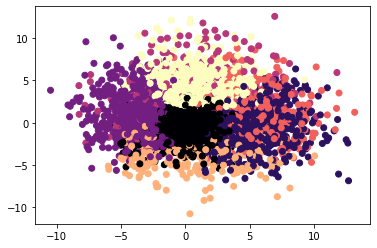

In [37]:
#Visualizing negative k-means clusters
kmeans_visualize(kmeans_negative, negative_vectors)

#### Although we couldn't find a group that represents each of the parts of speech, we can see that for each model there is a group that stands out in the number of adjectives and adverbs that's in it. 
#### We will emphasize that adjectives and adverbs are just as important as nouns for finding characteristics.
#### Now, with a file that contains adjectives and adverbs from the English dictionary, we will find the group that has the greatest amount of adjectives and adverbs relative to its size.<br>We will find this group for the positive model and the negative model.

In [38]:
#Loading all english word adj and adv
with open("adj_adv.txt", "rb") as fp:   
    adj_adv_words = pickle.load(fp)

In [39]:
#Function that returns the group with the greatest amount of adj and adv
def most_adj(words_lst, model, adj_adv_words):
    
    words_in_clusters = defaultdict(list)
    
    for i,word in enumerate(words_lst):
        pred = model.labels_[i]
        words_in_clusters[pred].append(word) 
        
    keys_list = list(words_in_clusters.keys())
    adj_amount_in_each_group = len(words_in_clusters)*[0]
    
    for i in sorted(keys_list):
        for word in words_in_clusters[i]: 
            if word in adj_adv_words:
                adj_amount_in_each_group[i] += 1
                
    adj_ratio_each_group = [amount/len(words_in_clusters[i]) for i,amount in enumerate(adj_amount_in_each_group)]
    
    return (adj_ratio_each_group.index(max(adj_ratio_each_group))), max(adj_ratio_each_group)

In [40]:
#Function that returns all the words that belong to specific group
def AllWordsFromSpecificCluster(words_lst,model,specific_group_num):
    words_from_specific_group=[]
    
    for i,word in enumerate(words_lst):
        pred=model.labels_[i] 
        if pred == specific_group_num:
            words_from_specific_group.append(word) 
    
    return words_from_specific_group

In [41]:
max_adj_pos_group, adj_ratio_positive_group = most_adj(positive_words, kmeans_positive, adj_adv_words)
print(f'The positive group with the greatest amount of Adjectives is group number {max_adj_pos_group}')

words_from_specific_positive_group = AllWordsFromSpecificCluster(positive_words,kmeans_positive, max_adj_pos_group)
print("The amount of words in this group",len(words_from_specific_positive_group))

print(f'The ratio between the amount of adjectives we found in this group and the size of the group is {round(adj_ratio_positive_group, 2)}')

The positive group with the greatest amount of Adjectives is group number 4
The amount of words in this group 1154
The ratio between the amount of adjectives we found in this group and the size of the group is 0.22


In [42]:
#printing the 10 head from specific positive group 
words_from_specific_positive_group[:10]

['awesome',
 'interesting',
 'love',
 'fantastic',
 'third',
 'purchasing',
 'will',
 'looking',
 'loves',
 'wonderful']

In [43]:
max_adj_neg_group, adj_ratio_negative_group = most_adj(negative_words, kmeans_negative, adj_adv_words)
print(f'The negative group with the greatest amount of Adjectives is group number {max_adj_neg_group}')

words_from_specific_negative_group = AllWordsFromSpecificCluster(negative_words,kmeans_negative, max_adj_neg_group)
print("The amount of words in this group",len(words_from_specific_negative_group))

print(f'The ratio between the amount of adjectives we found in this group and the size of the group is {round(adj_ratio_negative_group, 2)}')

The negative group with the greatest amount of Adjectives is group number 5
The amount of words in this group 551
The ratio between the amount of adjectives we found in this group and the size of the group is 0.59


In [44]:
#printing the 10 head from specific negative group 
words_from_specific_negative_group[:10]

['much',
 'small',
 'fine',
 'hot',
 'described',
 'does',
 'clear',
 'cheap',
 'different',
 'disappointed']

#### After finding the groups that are dominant in the number of adjectives and adverbs, we will look for combinations through all sentences, where a word from one of the groups is a part of them.<br>We will do this for the positive and negative reviews.
#### But first, we take a look at the words that repeat themselves most frequently in all reviews so we can see what our combinations might include.

In [45]:
#Function to plot most frequent terms
def freq_words(x, terms = 30):
    fdist = FreqDist(x)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show() 

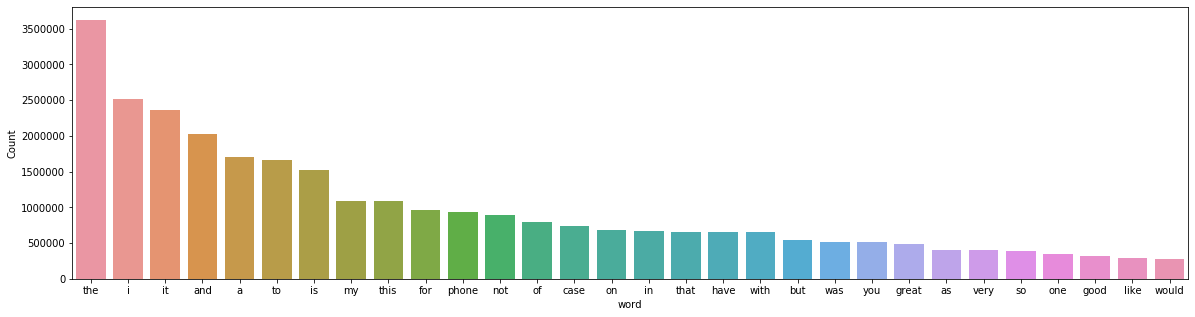

In [46]:
#plot most frequent positive terms
pos_freq_check_words = list(itertools.chain.from_iterable(df_positive_reviews['reviewSentences']))
pos_freq_check_words = list(itertools.chain.from_iterable(pos_freq_check_words))

freq_words(pos_freq_check_words)

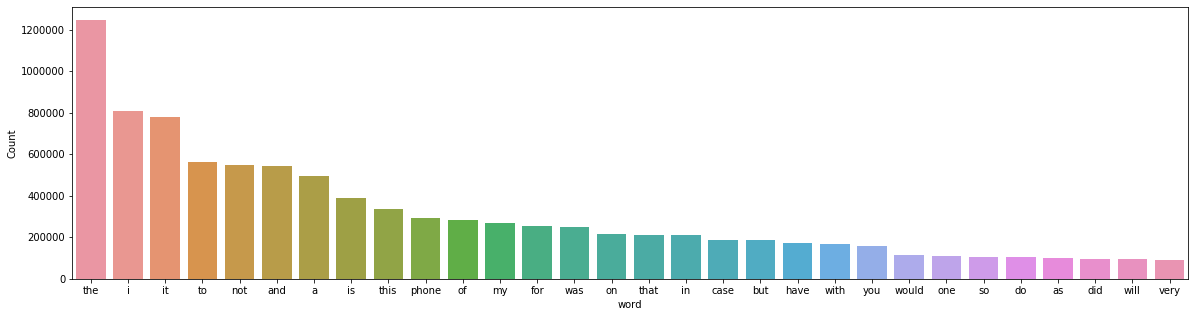

In [47]:
#plot most frequent negative terms
neg_freq_check_words = list(itertools.chain.from_iterable(df_negative_reviews['reviewSentences']))
neg_freq_check_words = list(itertools.chain.from_iterable(neg_freq_check_words))

freq_words(neg_freq_check_words)

#### As we can see in the diagrams above, many of the repetitive words don't contribute us.<br>For our combinations to be as relevant as possible, we will remove these words, known as stopwords.
#### Note:<br>We haven't removed these words in the cleaning stage so that Word2Vec will understand the relationships between the words in the best way.

In [48]:
#ourstopword contains stopwords without negative words 

OUR_STOP_WORDS =STOP_WORDS

#We remove this words from OUR_STOP_WORDS because we want to keep negative words that might be important for our goal
for i in ['not','cannot','nor','nothing','neither','none','no','never','off','nowhere','but','however','else','nobody','empty']:
    OUR_STOP_WORDS.remove(i)

In [49]:
#Function that returns all possible combinations in size k, that contain Adjective-Adverb from group_adj. 
def getSentenceTuple(sentence,k,group_adj):
    
    #Remove stopwords except negative words
    sentence = [word for word in sentence if word not in set(OUR_STOP_WORDS)]
    sentence_tuple=set()
    
    for i,word in enumerate(sentence):
        if word not in group_adj:
            continue
        min_j= max([0,i-k+1])
        max_j= min([len(sentence)-k,i]) 
        for j in range(min_j,max_j+1,1):
            tuple_j= tuple(sentence[j:j+k])
            sentence_tuple.add(tuple_j)
            
    return sentence_tuple

In [50]:
#Function that returns the review tuples
def getReviewTuple(review_sentences, k, group_adj):
    
    review_tuple=set()

    for sentence in review_sentences:
        set_sen= set(sentence)
        if any(word in set_sen for word in group_adj):
            review_tuple = set(review_tuple)|set(getSentenceTuple(sentence,k,group_adj))   
    
    return review_tuple

In [51]:
#Function that returns a dictionary whose keys are sequences with adjectives  
#The value of each key is the number of times it appears in all the reviews
def getDictionaryAdvAndAdj(reviews, k, group_adj):
    
    tuples_count={}
    
    for review_sentences in reviews:
        review_tuples =getReviewTuple(review_sentences, k, group_adj)
        
        for words_tup in review_tuples:
            tuples_count[words_tup]= tuples_count.get(words_tup,0)+1
                    
    return tuples_count

In [52]:
#create a dicionary for the positve reviews sentences that include the adjective specific group
cellphones_positive_tuples_count = getDictionaryAdvAndAdj(df_positive_reviews['reviewSentences'], 3, words_from_specific_positive_group)

In [53]:
#save the positive tuples count dictionary
with open('cellphone_word2vec_positive_tuples_count.txt',mode='w') as pos_file:
    json.dump(json.dumps({str(k): v for k, v in cellphones_positive_tuples_count.items()}), pos_file)

In [54]:
#create a dicionary for the negative reviews sentences that include the adjective specific group
cellphones_negative_tuples_count= getDictionaryAdvAndAdj(df_negative_reviews['reviewSentences'], 3, words_from_specific_negative_group)

In [55]:
#save the negative tuples count dictionary
with open('cellphone_word2vec_negative_tuples_count.txt',mode='w') as pos_file:
    json.dump(json.dumps({str(k): v for k, v in cellphones_negative_tuples_count.items()}), pos_file)

In [56]:
with open('Cellphones/word2vec/cellphone_word2vec_positive_tuples_count.txt',mode='r') as pos_file:
    cellphones_positive_tuples_count = json.loads(json.load(pos_file))

In [57]:
with open('Cellphones/word2vec/cellphone_word2vec_negative_tuples_count.txt',mode='r') as neg_file:
    cellphones_negative_tuples_count = json.loads(json.load(neg_file))

In [58]:
#printing the 100-head 
for i,key in enumerate(cellphones_positive_tuples_count.keys()):
    print(key)
    if i==100:
        break    

('great', 'wall', 'art')
('interesting', 'spacerelated', 'photos')
('quality', 'calendar', 'interesting')
('calendar', 'interesting', 'spacerelated')
('bunch', 'awesome', 'information')
('sturdy', 'bunch', 'awesome')
('desk', 'calendar', 'great')
('great', 'calendar', 'space')
('wonderful', 'astonomical', 'photographs')
('includes', 'lots', 'wonderful')
('lots', 'wonderful', 'astonomical')
('astonomical', 'photographs', 'interesting')
('interesting', 'information', 'verious')
('photographs', 'interesting', 'information')
('best', 'space', 'calendars')
('facts', 'calendar', 'best')
('calendar', 'best', 'space')
('high', 'school', 'class')
('big', 'hit', 'students')
('hung', 'high', 'school')
('beautiful', 'pictures', 'lot')
('lover', 'beautiful', 'pictures')
('astronomy', 'lover', 'beautiful')
('nice', 'delivered', 'box')
('nice', 'pictures', 'detail')
('interesting', 'facts', 'easy')
('filled', 'interesting', 'facts')
('facts', 'easy', 'use')
('beautifully', 'filled', 'interesting')
('

In [59]:
#printing the 100-head 
for i,key in enumerate(cellphones_negative_tuples_count.keys()):
    print(key)
    if i==100:
        break    

('calendar', 'fine', 'print')
('small', 'calendar', 'fine')
('leaves', 'small', 'calendar')
('pages', 'leaves', 'small')
('hot', 'work', 'described')
('pretty', 'clear', 'cheap')
('nice', 'quality', 'product')
('thought', 'purchasing', 'nice')
('quality', 'product', 'samsung')
('purchasing', 'nice', 'quality')
('sense', 'donate', 'likely')
('prob', 'better', 'ipod')
('ipod', 'nice', 'item')
('better', 'ipod', 'nice')
('item', 'shipping', 'quick')
('nice', 'item', 'shipping')
('stars', 'looks', 'great')
('love', 'way', 'case')
('plastic', 'great', 'looks')
('quality', 'great', 'looks')
('case', 'high', 'density')
('amazing', 'lots', 'compliments')
('fit', 'quality', 'great')
('high', 'density', 'plastic')
('looks', 'amazing', 'lots')
('density', 'plastic', 'great')
('great', 'looks', 'feel')
('great', 'looks', 'amazing')
('wish', 'but', 'bad')
('but', 'bad', 'reception')
('cool', 'metal', 'case')
('not', 'love', 'case')
('cool', 'case', 'concept')
('love', 'case', 'but')
('makes', 'phon

In [60]:
#Creating a dictionary whose key is a tuple.
#the value of each key is a set that contains the incidence of the tuple in positive responses, and negative responses
def TopList(positive_tuples_count,negative_tuples_count,amount_positive_reviews,amount_negative_reviews,top_num):

    all_tuples= set(positive_tuples_count)|set(negative_tuples_count)
   
    tuple_scores = {}

    for word_tup in all_tuples:
        positive_score = positive_tuples_count.get(word_tup,0)/amount_positive_reviews
        negative_score = negative_tuples_count.get(word_tup,0)/amount_negative_reviews
        tuple_scores[word_tup] = (positive_score,negative_score)
       
    #The tuples that appear relatively more in positive reviews
    top_positive= sorted(tuple_scores.items(),key = lambda t: t[1][0], reverse = True)[:top_num]
    #The tuples that appear relatively more in negative reviews
    top_negative= sorted(tuple_scores.items(),key = lambda t: t[1][1], reverse = True)[:top_num]    
   
    return top_positive,top_negative

In [61]:
#The tuples that appear relatively more in positive reviews and negative reviews
cellphones_amount_positive_reviews= df_positive_reviews.shape[0]
cellphones_amount_negative_reviews= df_negative_reviews.shape[0]
cellphones_top_positive, cellphones_top_negative = TopList(cellphones_positive_tuples_count,cellphones_negative_tuples_count,cellphones_amount_positive_reviews,cellphones_amount_negative_reviews,20)

In [62]:
cellphones_top_positive

[("('fits', 'phone', 'perfectly')", (0.004527463301665908, 0.0)),
 ("('not', 'big', 'deal')", (0.0031178161530814406, 0.001095385687790184)),
 ("('fits', 'like', 'glove')", (0.0029852185591250544, 0.0001643078531685276)),
 ("('thing', 'not', 'like')", (0.0027178961370846397, 0.00038836401658015607)),
 ("('case', 'fits', 'perfectly')", (0.0022314685998970417, 0.0)),
 ("('great', 'product', 'great')",
  (0.0019208924172612286, 1.7426590487571107e-05)),
 ("('product', 'great', 'price')",
  (0.001842184754538454, 3.236366804834634e-05)),
 ("('works', 'like', 'charm')",
  (0.0018308395058576937, 0.00010704905585222252)),
 ("('fit', 'phone', 'perfectly')", (0.0015472082888386863, 0.0)),
 ("('not', 'feel', 'like')", (0.0015365721182004734, 0.0010356373775470828)),
 ("('feels', 'good', 'hand')", (0.0014018472901164449, 0.0001792449307293028)),
 ("('great', 'job', 'protecting')",
  (0.0013288122517340505, 0.00014190223682736472)),
 ("('great', 'customer', 'service')",
  (0.0013266850176064078, 

In [63]:
cellphones_top_negative

[("('not', 'worth', 'money')", (5.3889931233611435e-05, 0.005947446382115339)),
 ("('but', 'not', 'worth')", (0.00011770695506288814, 0.002671247370451971)),
 ("('not', 'look', 'like')", (0.0009714369182901009, 0.002360058254602487)),
 ("('not', 'worth', 'time')", (2.5526809531710678e-05, 0.0018696242080237001)),
 ("('not', 'able', 'use')", (0.0, 0.0017899597943662323)),
 ("('looks', 'nice', 'but')", (0.00016734241804121445, 0.0017078058677819684)),
 ("('not', 'good', 'quality')",
  (0.00012054326723307821, 0.0016032463248565419)),
 ("('not', 'worth', 'price')", (3.332666799973339e-05, 0.001481260191443544)),
 ("('but', 'not', 'good')", (0.0003644661138694247, 0.0014190223682736473)),
 ("('cute', 'but', 'not')", (0.00015103362306262153, 0.0014090643165664638)),
 ("('good', 'but', 'not')", (0.0006438428626331471, 0.0014090643165664638)),
 ("('not', 'good', 'product')",
  (3.049035582954331e-05, 0.0013941272390056885)),
 ("('not', 'happy', 'product')", (0.0, 0.001386658700225301)),
 ("('

In [64]:
def VisualizingTopTuples(pos_neg,top):
    
    x = [str(tup[0]) for tup in top]
    y = [incidence[1][pos_neg] for incidence in top]
    
    # Create a dataframe
    visualize_df = pd.DataFrame({'tuples': x, 'frequencies': y })

    # Reorder it following the values:
    ordered_df = visualize_df.sort_values(by='frequencies')
    my_range = range(1,len(visualize_df.index)+1)

    # The vertival plot is made using the hline function
    plt.hlines(y=my_range, xmin=0, xmax=ordered_df['frequencies'], color='skyblue')
    plt.plot(ordered_df['frequencies'], my_range, "o")

    # Add titles and axis names
    plt.yticks(my_range, ordered_df['tuples'])
    plt.title("Tuple frequencies", loc='left')
    plt.xlabel('frequencies')
    plt.ylabel('tuples')

#### As we can see, in our top positive tuples result, we get tuples such as ('sound', 'quality', 'good') and ('fits', 'phone', 'perfectly') that helps us understand some of the positive general characteristics of the Cellphones and accessories category.

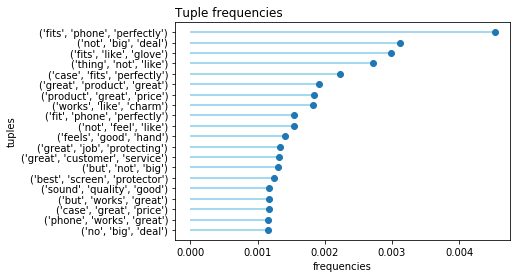

In [65]:
#Visualizing top positive Cellphones and Accessories
VisualizingTopTuples(0,cellphones_top_positive)

#### Here as well, we get tuples that express some of the negative general characteristics of the Cellphones category<br>such as ('not' ,'good', 'quality').

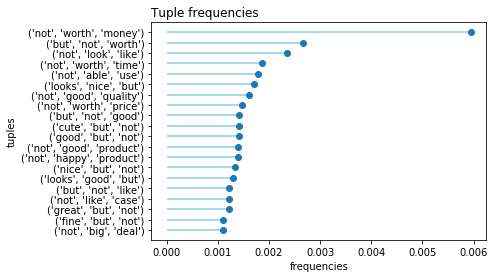

In [66]:
#Visualizing top negative Cellphones and Accessories
VisualizingTopTuples(1,cellphones_top_negative)

In [67]:
#Displaying the prevalence for each top 20 tuples in the negative and positive dictionaries
def VisualizingTopTuplesNegative_Positive(top_positive,top_negative):
    
    Xpos_positive = [tup[1][0] for tup in top_positive]
    Yneg_positive = [tup[1][1] for tup in top_positive]

    Xpos_negative = [tup[1][0] for tup in top_negative]
    Yneg_negative = [tup[1][1] for tup in top_negative]

    plt.xlabel('Prevalence in the positive tuple count')
    plt.ylabel('Prevalence in the negative tuple count')
        
    sns.regplot(x=Xpos_positive, y=Yneg_positive, fit_reg=False)
    sns.regplot(x=Xpos_negative, y=Yneg_negative, fit_reg=False)

#### Most positive and negative tuples appear in lower prevalence in each other.

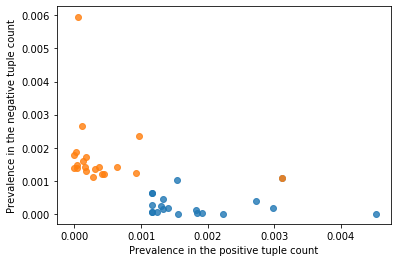

In [68]:
#Displaying the prevalence for each top 20 tuples in the negative and positive Cellphones dictionaries
VisualizingTopTuplesNegative_Positive(cellphones_top_positive,cellphones_top_negative)

<br>

<br>
__________________________________________________________________________________________________________________________

### As we did for the Cellphones and Accessories dataset, we also tested this model on the Automotive and Electronics datasets.<br>Let's look at their results.
##### Note: For the tutorial to be focused from now on, we will only show the significant results and differences.

### Electronics

##### Word2Vec models

In [69]:
#Loading Electronics w2v positive and negative files
electronics_positive_words = []
with open('Electronics/word2vec/electronics_word2vec_positive_words.txt',mode='r') as pos_words:
            electronics_positive_words = json.load(pos_words)
        
electronics_positive_vectors =np.load("Electronics/word2vec/electronics_word2vec_positive_vectors.npy")


electronics_negative_words = []
with open('Electronics/word2vec/electronics_word2vec_negative_words.txt',mode='r') as neg_words:
            electronics_negative_words = json.load(neg_words)
        
electronics_negative_vectors = np.load("Electronics/word2vec/electronics_word2vec_negative_vectors.npy")

#### As we can see for the first 100 positive words, we have some good results, e.g, "love" and "like" or "felt" and "feel".

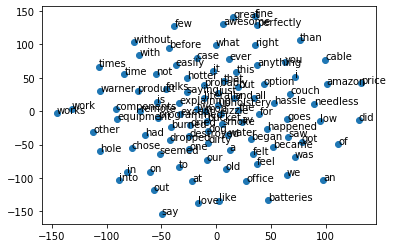

In [70]:
#Visualizing the head-100 positive words in Electronics W2V model
w2v_visualize(electronics_positive_vectors, electronics_positive_words)

#### We got some good results here as well, e.g, "bottom" and "top".

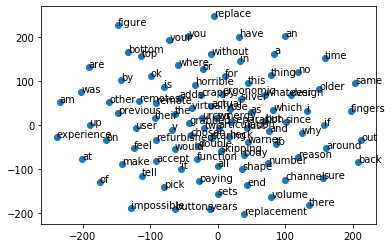

In [71]:
#Visualizing the head-100 negative words in Electronics W2V model
w2v_visualize(electronics_negative_vectors, electronics_negative_words)

##### K-means clustering

In [72]:
#Positive Electronics k-means
electronics_kmeans_positive = KMeans(n_clusters=7, random_state=500).fit(electronics_positive_vectors)
WordsFromEachCluster(electronics_positive_words,electronics_kmeans_positive,20)

GROUP  0
old
warner
cable
what
price
amazon
this
one
chose
that
i
ever
twc
other
av
product
unit
only
another
exact



GROUP  1
remote
to
folks
option
times
batteries
anything
equipment
components
you
programming
program
device
spectrum
controls
volume
service
code
networks
lights



GROUP  2
and
did
not
at
on
for
perfectly
was
had
an
into
a
of
mop
out
seemed
except
few
began
sizzle



GROUP  3
got
destroyed
explaining
happened
saw
works
dropped
work
became
burned
say
programmed
goes
get
buy
needed
duplicate
control
ask
reccomend



GROUP  4
the
it
feel
right
dirty
water
dried
hole
easily
case
logo
chair
box
too
broken
looks
worn
silver
bar
red



GROUP  5
dog
time
office
we
bucket
smoke
our
couch
my
wife
her
me
northern
california
us
who
house
night
trying
ours



GROUP  6
like
low
hassle
fine
hotter
awesome
great
saying
better
ok
needs
easy
able
described
perfect
well
problem
question
cool
bright





#### We get three strong clusters and the rest are mixed.

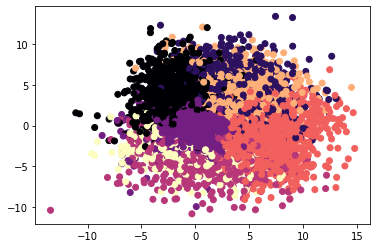

In [73]:
#Visualize k-means positive model
kmeans_visualize(electronics_kmeans_positive, electronics_positive_vectors)

In [74]:
#Negative Electronics k-means
electronics_kmeans_negative = KMeans(n_clusters=7, random_state=500).fit(electronics_negative_vectors)
WordsFromEachCluster(electronics_negative_words,electronics_kmeans_negative,20)

GROUP  0
for
whatever
was
chosen
by
warner
synergy
of
is
but
are
no
separation
as
on
up
a
would
twc
virtually



GROUP  1
replace
accept
pick
use
make
have
feel
figure
tell
be
upgrade
go
learn
need
work
pull
know
give
change
return



GROUP  2
silver
the
design
and
shape
it
where
your
fingers
around
out
top
bottom
body
end
stuck
head
blue
red
yellow



GROUP  3
adds
skipping
fails
hit
purchased
worked
malfunctioning
holding
busted
exchanged
malfunction
has
repeated
using
each
ordered
replaced
needed
pressed
stopped



GROUP  4
actual
ok
ergonomic
there
crappy
impossible
sure
horrible
can
biggest
learning
like
included
normal
cool
heavier
sucks
bad
close
hard



GROUP  5
remote
reason
time
function
sets
remotes
buttons
all
volume
channel
user
you
thing
players
problem
streaming
setting
code
methods
program



GROUP  6
this
to
their
previous
v
back
years
same
number
other
experience
why
replacement
since
which
i
paying
refurbished
an
older





#### In this case, we get four dominant clusters and the other are mixed.

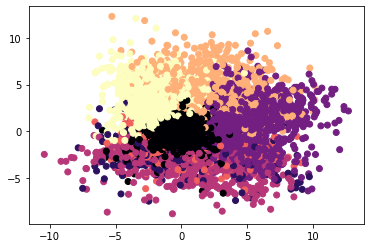

In [75]:
#Visualize k-means negative model
kmeans_visualize(electronics_kmeans_negative, electronics_negative_vectors)

In [76]:
max_adj_pos_group, adj_ratio_positive_group = most_adj(electronics_positive_words, electronics_kmeans_positive, adj_adv_words)
print(f'The positive group with the greatest amount of Adjectives is group number {max_adj_pos_group}')

words_from_specific_positive_group = AllWordsFromSpecificCluster(electronics_positive_words,electronics_kmeans_positive, max_adj_pos_group)
print("The amount of words in this group",len(words_from_specific_positive_group))

print(f'The ratio between the amount of adjectives we found in this group and the size of the group is {round(adj_ratio_positive_group, 2)}')

The positive group with the greatest amount of Adjectives is group number 6
The amount of words in this group 1339
The ratio between the amount of adjectives we found in this group and the size of the group is 0.44


In [77]:
#printed the 10 head from specific positive group 
words_from_specific_positive_group[:10]

['like',
 'low',
 'hassle',
 'fine',
 'hotter',
 'awesome',
 'great',
 'saying',
 'better',
 'ok']

In [78]:
max_adj_neg_group, adj_ratio_negative_group = most_adj(electronics_negative_words, electronics_kmeans_negative, adj_adv_words)
print(f'The negative group with the greatest amount of Adjectives is group number {max_adj_neg_group}')

words_from_specific_negative_group = AllWordsFromSpecificCluster(electronics_negative_words,electronics_kmeans_negative, max_adj_neg_group)
print("The amount of words in this group",len(words_from_specific_negative_group))

print(f'The ratio between the amount of adjectives we found in this group and the size of the group is {round(adj_ratio_negative_group, 2)}')

The negative group with the greatest amount of Adjectives is group number 4
The amount of words in this group 736
The ratio between the amount of adjectives we found in this group and the size of the group is 0.57


In [79]:
#printed the 10 head from specific negative group 
words_from_specific_negative_group[:10]

['actual',
 'ok',
 'ergonomic',
 'there',
 'crappy',
 'impossible',
 'sure',
 'horrible',
 'can',
 'biggest']

##### Dictionaries

In [80]:
#Loading Electronics dictionary positive files
with open('Electronics/word2vec/electronics_word2vec_positive_tuples_count.txt',mode='r') as pos_file:
    electronics_positive_tuples_count = json.loads(json.load(pos_file))

In [81]:
#Loading Electronics dictionary negative files
with open('Electronics/word2vec/electronics_word2vec_negative_tuples_count.txt',mode='r') as neg_file:
    electronics_negative_tuples_count = json.loads(json.load(neg_file))

In [82]:
#The tuples that appear relatively more in positive reviews and negative reviews
#Pre known amounts
electronics_amount_positive_reviews = 3080564
electronics_amount_negative_reviews = 625164
electronics_top_positive, electronics_top_negative = TopList(electronics_positive_tuples_count,electronics_negative_tuples_count,electronics_amount_positive_reviews,electronics_amount_negative_reviews,20)

In [83]:
electronics_top_positive

[("('works', 'like', 'charm')",
  (0.0034396298859559484, 0.00040469380834469036)),
 ("('not', 'big', 'deal')", (0.0031727956309299207, 0.0014252260206921703)),
 ("('sound', 'quality', 'good')",
  (0.002928684487645769, 0.0019098988425437166)),
 ("('external', 'hard', 'drive')",
  (0.002085981657904202, 0.002151435463334421)),
 ("('good', 'sound', 'quality')",
  (0.0019950892109366985, 0.001185288980171603)),
 ("('sound', 'quality', 'great')",
  (0.0019778845691892782, 0.0007358069242630734)),
 ("('thing', 'not', 'like')", (0.0018207704822883082, 0.00036310472132112533)),
 ("('great', 'sound', 'quality')",
  (0.001732799578259046, 0.0005950438604910072)),
 ("('product', 'great', 'price')",
  (0.0017055318441687951, 4.9586988374250597e-05)),
 ("('great', 'product', 'great')",
  (0.0016389855883533015, 3.359118567287944e-05)),
 ("('worked', 'like', 'charm')",
  (0.0015529623796162002, 0.0005534547734674421)),
 ("('but', 'works', 'great')",
  (0.0014078590803502215, 0.00012316768080055795

In [84]:
electronics_top_negative

[("('not', 'worth', 'money')", (9.965707578222689e-05, 0.004630784882046951)),
 ("('but', 'not', 'worth')", (0.00018892644333959625, 0.0022810014652155275)),
 ("('sound', 'quality', 'not')", (0.0, 0.002221816995220454)),
 ("('external', 'hard', 'drive')",
  (0.002085981657904202, 0.002151435463334421)),
 ("('not', 'worth', 'time')", (4.771853465793926e-05, 0.001941890447946459)),
 ("('sound', 'quality', 'good')",
  (0.002928684487645769, 0.0019098988425437166)),
 ("('works', 'fine', 'but')", (0.0005804131970639142, 0.0016715613822932862)),
 ("('not', 'able', 'use')", (0.0005012069218493756, 0.001637970196620407)),
 ("('but', 'not', 'good')", (0.000620990182317264, 0.0016203748136488986)),
 ("('not', 'worth', 'price')", (7.336318933805628e-05, 0.0016123769122982129)),
 ("('fine', 'but', 'not')", (0.0003736328802128441, 0.001545194540952454)),
 ("('good', 'but', 'not')", (0.0011452448317905422, 0.001545194540952454)),
 ("('not', 'worth', 'hassle')",
  (4.479699171969808e-05, 0.0014652155

#### Here, we have some nice results such as ('takes', 'great', 'pictures'), ('good', 'sound', 'quality')

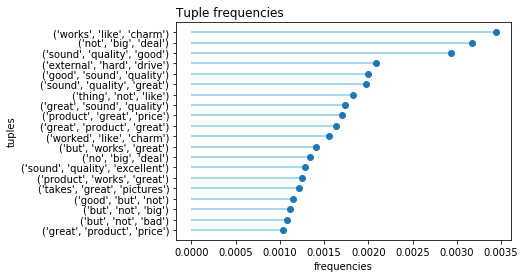

In [85]:
#Visualizing top positive electronics
VisualizingTopTuples(0,electronics_top_positive)

#### We are getting nice results here as well, such as ('sound', 'quality', 'poor') although controversy to the top positive results we need to remember that each review can belong to different products in the Electronics category.

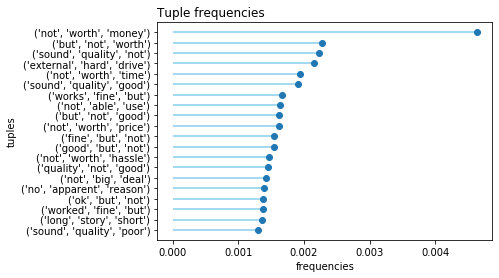

In [86]:
#Visualizing top negative electronics
VisualizingTopTuples(1,electronics_top_negative)

#### Some combinations are in both lists, the positive and the negative.<br>The possible reason for it is that negative reviews are rated 1-2 and we may encounter positive characteristics of products in ratings 2.

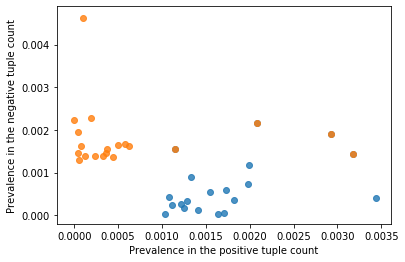

In [87]:
#Displaying the prevalence for each top 20 tuples in the negative and positive Electronics dictionaries
VisualizingTopTuplesNegative_Positive(electronics_top_positive,electronics_top_negative)

<br>

<br>
__________________________________________________________________________________________________________________________

### Automotive

##### Word2Vec models

In [88]:
#Loading Automotive w2v positive and negative files
automotive_positive_words = []
with open('Automotive/word2vec/automotive_word2vec_positive_words.txt',mode='r') as pos_words:
            automotive_positive_words = json.load(pos_words)
        
automotive_positive_vectors = np.load('Automotive/word2vec/automotive_word2vec_positive_vectors.npy')


automotive_negative_words = []
with open('Automotive/word2vec/automotive_word2vec_negative_words.txt',mode='r') as neg_words:
            automotive_negative_words = json.load(neg_words)
        
automotive_negative_vectors = np.load("Automotive/word2vec/automotive_word2vec_negative_vectors.npy")

#### Some of the words with close meanings have close vectors, e.g, "can","will","may" and "would" or "phone","phones" and "devices"

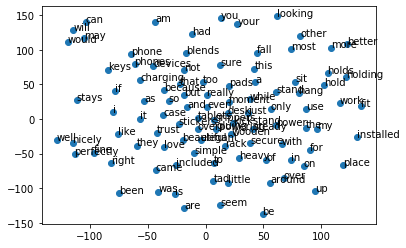

In [89]:
#Visualizing the head-100 positive words in Automotive W2V model
w2v_visualize(automotive_positive_vectors, automotive_positive_words)

#### Here, if we look closely we can see that there are some nice results such as, "color" and "black" or "bought" and "purchased"

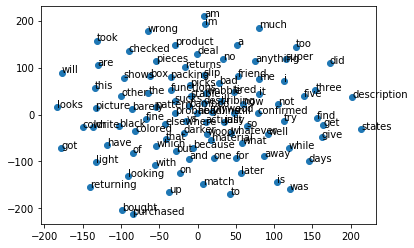

In [90]:
#Visualizing the head-100 negative words in Automotive W2V model
w2v_visualize(automotive_negative_vectors, automotive_negative_words)

##### K-means clustering

In [91]:
#Positive Automotive k-means
automotive_kmeans_positive = KMeans(n_clusters=7, random_state=500).fit(automotive_positive_vectors)
WordsFromEachCluster(automotive_positive_words,automotive_kmeans_positive,20)

GROUP  0
is
fine
just
would
a
more
as
am
not
gluing
of
but
for
and
in
with
if
elegant
on
had



GROUP  1
the
to
little
secure
right
wooden
place
nicely
included
pads
around
case
kickstand
rack
tad
up
end
table
bed
instead



GROUP  2
holds
stays
installed
stand
your
use
sit
hang
came
hold
work
holding
fall
pop
having
turn
placed
goes
used
trying



GROUP  3
like
sure
trust
simple
love
looking
better
can
may
overpowering
will
meaning
could
able
do
says
given
receive
honest
basic



GROUP  4
it
stickers
beautiful
blends
really
even
seem
heavy
hands
touch
does
off
wood
environment
garbage
looks
cleaner
its
anything
wash



GROUP  5
be
power
moment
keys
you
phone
charging
tablets
other
devices
phones
tablet
everything
device
opportunity
exchange
unbiased
review
opinions
one



GROUP  6
i
my
desk
this
been
fit
perfectly
own
bought
landscape
husband
he
him
office
them
car
home
second
gift
mom





#### In this case we can notice that most of the clusters are mixed.<br>This may indicate that the results will be of lower quality.

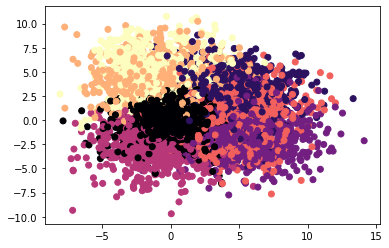

In [92]:
#Visualize k-means positive model
kmeans_visualize(automotive_kmeans_positive, automotive_positive_vectors)

In [93]:
#Negative Automotive k-means
automotive_kmeans_negative = KMeans(n_clusters=7, random_state=500).fit(automotive_negative_vectors)
WordsFromEachCluster(automotive_negative_words, automotive_kmeans_negative,20)

GROUP  0
me
returns
returning
deal
product
description
picture
this
have
what
give
friend
try
find
am
confirmed
anything
money
write
be



GROUP  1
three
one
it
still
but
just
while
a
light
i
color
five
days
later
now
fuses
car
than
v
consistently



GROUP  2
is
super
whatever
im
tired
ill
with
because
actually
functions
are
describing
headline
bamboo
colored
other
was
vs
plywood
no



GROUP  3
stable
bad
well
fine
much
darker
white
looking
short
quickly
easy
great
disappointing
terrible
quality
made
worse
powerful
nice
long



GROUP  4
took
get
wobble
shows
got
checked
slip
picks
blew
turns
wiggle
clean
running
use
gave
used
stopped
had
takes
pick



GROUP  5
did
not
wrong
states
bought
match
purchased
cars
work
vehicle
doesnt
my
husband
though
truck
husbands
mercedes
ordered
neither
didnt



GROUP  6
to
that
and
of
so
too
the
looks
wood
pieces
box
black
material
packing
on
pattern
which
barely
up
connection





#### We can see that there are three dominant clusters and the other are mixed

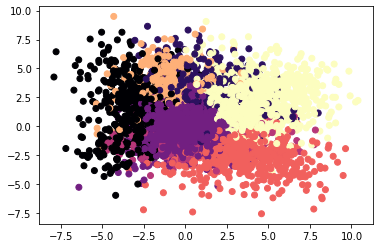

In [94]:
#Visualize k-means negative model
kmeans_visualize(automotive_kmeans_negative, automotive_negative_vectors)

In [95]:
max_adj_pos_group, adj_ratio_positive_group = most_adj(automotive_positive_words, automotive_kmeans_positive, adj_adv_words)
print(f'The positive group with the greatest amount of Adjectives is group number {max_adj_pos_group}')

words_from_specific_positive_group = AllWordsFromSpecificCluster(automotive_positive_words,automotive_kmeans_positive, max_adj_pos_group)
print("The amount of words in this group",len(words_from_specific_positive_group))

print(f'The ratio between the amount of adjectives we found in this group and the size of the group is {round(adj_ratio_positive_group, 2)}')

The positive group with the greatest amount of Adjectives is group number 3
The amount of words in this group 1213
The ratio between the amount of adjectives we found in this group and the size of the group is 0.29


In [96]:
#printed the 10 head from specific positive group 
words_from_specific_positive_group[:10]

['like',
 'sure',
 'trust',
 'simple',
 'love',
 'looking',
 'better',
 'can',
 'may',
 'overpowering']

In [97]:
max_adj_neg_group, adj_ratio_negative_group = most_adj(automotive_negative_words, automotive_kmeans_negative, adj_adv_words)
print(f'The negative group with the greatest amount of Adjectives is group number {max_adj_neg_group}')

words_from_specific_negative_group = AllWordsFromSpecificCluster(automotive_negative_words,automotive_kmeans_negative, max_adj_neg_group)
print("The amount of words in this group",len(words_from_specific_negative_group))

print(f'The ratio between the amount of adjectives we found in this group and the size of the group is {round(adj_ratio_negative_group, 2)}')

The negative group with the greatest amount of Adjectives is group number 3
The amount of words in this group 414
The ratio between the amount of adjectives we found in this group and the size of the group is 0.63


In [98]:
#printed the 10 head from specific negative group 
words_from_specific_negative_group[:10]

['stable',
 'bad',
 'well',
 'fine',
 'much',
 'darker',
 'white',
 'looking',
 'short',
 'quickly']

##### Dictionaries

In [99]:
#Loading Automotive dictionary positive files
with open('Automotive/word2vec/automotive_word2vec_positive_tuples_count.txt',mode='r') as pos_file:
    automotive_positive_tuples_count = json.loads(json.load(pos_file))

In [100]:
#Loading Automotive dictionary negative files # Empty file
with open('Automotive/word2vec/automotive_word2vec_negative_tuples_count.txt',mode='r') as neg_file:
    automotive_negative_tuples_count = json.loads(json.load(neg_file))

In [101]:
#The tuples that appear relatively more in positive reviews and negative reviews
#Pre known amounts
automotive_amount_positive_reviews = 3269721
automotive_amount_negative_reviews = 477639
automotive_top_positive, automotive_top_negative = TopList(automotive_positive_tuples_count,automotive_negative_tuples_count,automotive_amount_positive_reviews,automotive_amount_negative_reviews,20)

In [102]:
automotive_top_positive

[("('works', 'like', 'charm')", (0.002064702156544855, 0.0001444605654060912)),
 ("('highly', 'recommend', 'product')", (0.001972951208986944, 0.0)),
 ("('worked', 'like', 'charm')",
  (0.0017600890106525908, 0.0002512357659236369)),
 ("('not', 'beat', 'price')", (0.0016674205536191008, 0.0)),
 ("('fit', 'like', 'glove')", (0.0015099147603113538, 0.0001947077185908186)),
 ("('not', 'big', 'deal')", (0.0013221311543094962, 0.0)),
 ("('fits', 'like', 'glove')", (0.001176858820676137, 5.8621678715515275e-05)),
 ("('product', 'good', 'price')",
  (0.0009511514896836763, 2.9310839357757637e-05)),
 ("('no', 'big', 'deal')", (0.0008441087175327804, 0.0)),
 ("('good', 'quality', 'product')",
  (0.0008092433574607742, 0.0001758650361465458)),
 ("('price', 'not', 'beat')", (0.0007303375425609708, 0.0)),
 ("('good', 'product', 'good')",
  (0.0006927196540622273, 3.559173350584856e-05)),
 ("('goes', 'long', 'way')", (0.0006795686849122601, 0.0)),
 ("('definitely', 'recommend', 'product')", (0.0006

In [103]:
automotive_top_negative

[("('not', 'look', 'like')", (0.0004492738065419037, 0.0016728114747748823)),
 ("('good', 'but', 'not')", (0.0004275594156198648, 0.0014508865482090031)),
 ("('looks', 'good', 'but')", (0.00018503107757512032, 0.001302238720037518)),
 ("('not', 'good', 'quality')",
  (5.5968078010325654e-05, 0.0012478043040873965)),
 ("('not', 'good', 'product')",
  (2.2020227413898618e-05, 0.0011159055269774872)),
 ("('but', 'not', 'good')", (0.00017707932878676804, 0.0010049430636945476)),
 ("('ok', 'but', 'not')", (0.0001315096914996723, 0.0009819131184848808)),
 ("('looks', 'great', 'but')", (0.0, 0.0008793251807327292)),
 ("('nice', 'but', 'not')", (0.0, 0.0008500143413749714)),
 ("('good', 'quality', 'but')",
  (0.00023518826224011162, 0.0007725499802151834)),
 ("('not', 'fit', 'like')", (6.14731348638003e-05, 0.000730677352561244)),
 ("('good', 'product', 'but')", (0.00033611430455381363, 0.00072649008979585)),
 ("('looks', 'nice', 'but')", (0.0, 0.0007160219328823652)),
 ("('but', 'not', 'like'

#### The results here are more general but it makes sense because we analyze a full category and not a specific product.

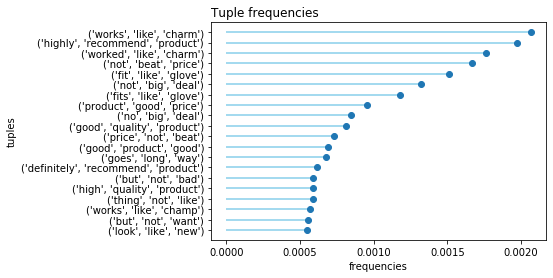

In [104]:
#Visualizing top positive Automotive
VisualizingTopTuples(0,automotive_top_positive)

#### It seems that maybe the positive general characteristics are more prevalent than the negative characteristics, and that's why we don't see something interesting.

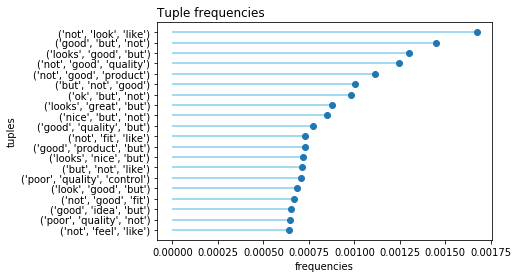

In [105]:
#Visualizing top negative Automotive
VisualizingTopTuples(1,automotive_top_negative)

#### We are going to check the assumption mentioned above and for that, we will look at tuples that are less prevalent.

In [106]:
#automotive_top_positive, automotive_top_negative = TopList(automotive_positive_tuples_count,automotive_negative_tuples_count,automotive_amount_positive_reviews,automotive_amount_negative_reviews,60)

#### Seems like our assumption was correct we can find more interesting negative characteristics than before.

In [107]:
automotive_top_negative[30:60]

[]

#### We can see here as well that some of the positive combinations also appear in the negative combinations and vice versa

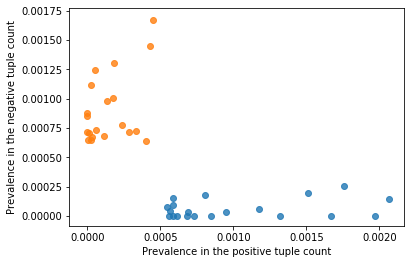

In [108]:
#Displaying the prevalence for each top 20 tuples in the negative and positive Automotive dictionaries
VisualizingTopTuplesNegative_Positive(automotive_top_positive,automotive_top_negative)

_______________________________________________________________________________________________________________________________

### After we examined each category separately, we will now compare the positive word combinations and the negative word combinations between the different categories.

#### We can see that there's an overlap between the top positive tuples of the different categories.

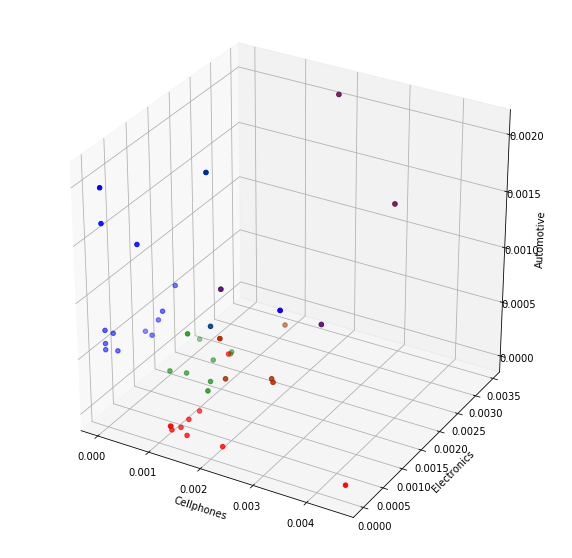

In [109]:
#Positive compare

Xpos_cellphones = [tup[1][0] for tup in cellphones_top_positive]
Ypos_cellphones = [((electronics_positive_tuples_count.get(tup[0],0))/electronics_amount_positive_reviews) for tup in cellphones_top_positive]
Zpos_cellphones = [((automotive_positive_tuples_count.get(tup[0],0))/automotive_amount_positive_reviews) for tup in cellphones_top_positive]

Xpos_electronics = [((cellphones_positive_tuples_count.get(tup[0],0))/cellphones_amount_positive_reviews) for tup in electronics_top_positive]
Ypos_electronics = [tup[1][0] for tup in electronics_top_positive]
Zpos_electronics = [((automotive_positive_tuples_count.get(tup[0],0))/automotive_amount_positive_reviews) for tup in electronics_top_positive]

Xpos_automotive = [((cellphones_positive_tuples_count.get(tup[0],0))/cellphones_amount_positive_reviews) for tup in automotive_top_positive]
Ypos_automotive = [((electronics_positive_tuples_count.get(tup[0],0))/electronics_amount_positive_reviews) for tup in automotive_top_positive]
Zpos_automotive = [tup[1][0] for tup in automotive_top_positive]


category_comparison_plot = plt.figure(figsize=(10,10)).gca(projection='3d')
category_comparison_plot.scatter(Xpos_cellphones, Ypos_cellphones, Zpos_cellphones, color="r")
category_comparison_plot.scatter(Xpos_electronics, Ypos_electronics, Zpos_electronics, color="g")
category_comparison_plot.scatter(Xpos_automotive, Ypos_automotive, Zpos_automotive, color="b")
category_comparison_plot.set_xlabel('Cellphones')
category_comparison_plot.set_ylabel('Electronics')
category_comparison_plot.set_zlabel('Automotive')

plt.show()

#### We can see that there's an overlap between the top negative tuples of the different categories.

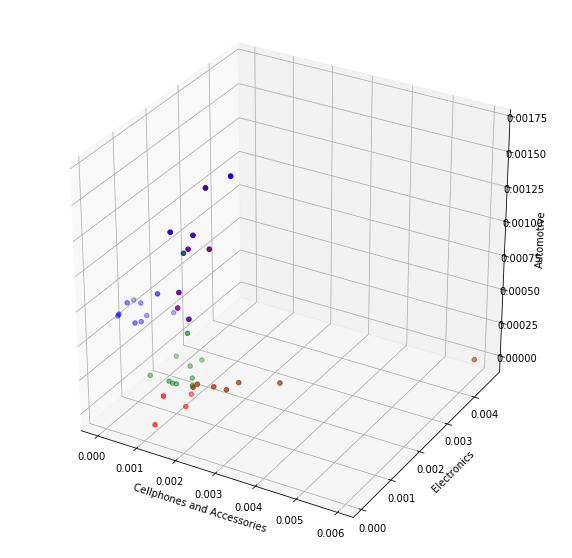

In [110]:
#Negative compare

Xneg_cellphones = [tup[1][1] for tup in cellphones_top_negative]
Yneg_cellphones = [((electronics_negative_tuples_count.get(tup[0],0))/electronics_amount_negative_reviews) for tup in cellphones_top_negative]
Zneg_cellphones = [((automotive_negative_tuples_count.get(tup[0],0))/automotive_amount_negative_reviews) for tup in cellphones_top_negative]

Xneg_electronics = [((cellphones_negative_tuples_count.get(tup[0],0))/cellphones_amount_negative_reviews) for tup in electronics_top_negative]
Yneg_electronics = [tup[1][1] for tup in electronics_top_negative]
Zneg_electronics = [((automotive_negative_tuples_count.get(tup[0],0))/automotive_amount_negative_reviews) for tup in electronics_top_negative]

Xneg_automotive = [((cellphones_negative_tuples_count.get(tup[0],0))/cellphones_amount_negative_reviews) for tup in automotive_top_negative]
Yneg_automotive = [((electronics_negative_tuples_count.get(tup[0],0))/electronics_amount_negative_reviews) for tup in automotive_top_negative]
Zneg_automotive = [tup[1][1] for tup in automotive_top_negative]

category_comparison_plot = plt.figure(figsize=(10,10)).gca(projection='3d')
category_comparison_plot.scatter(Xneg_cellphones, Yneg_cellphones, Zneg_cellphones, color="r")
category_comparison_plot.scatter(Xneg_electronics, Yneg_electronics, Zneg_electronics, color="g")
category_comparison_plot.scatter(Xneg_automotive, Yneg_automotive, Zneg_automotive, color="b")
category_comparison_plot.set_xlabel('Cellphones and Accessories')
category_comparison_plot.set_ylabel('Electronics')
category_comparison_plot.set_zlabel('Automotive')

plt.show()

<br>
__________________________________________________________________________________________________________________________

<br>

### Test on specific products from each category

#### To get a sense of whether word2vec with k-means solved our problem, we'll run it on a specific product for each category and test its results.

<br>

### Cellphones and accessories

In [81]:
#Loading Cellphones specific product data

cellphones_spec_df = pd.read_pickle("Cellphones/word2vec/specific/cellphones_specific_product.pickle")
cellphones_spec_df.head()

,asin,reviewText,overall,image,reviewSentences
0,B005NF5NTK,I got this product for my mom since she replac...,5.0,NaN,"[[i, got, this, product, for, my, mom, since, ..."
1,B005NF5NTK,"it charges my LG ""dumb"" phone, my echo ecigs, ...",5.0,NaN,"[[it, charges, my, lg, dumb, phone, my, echo, ..."
2,B005NF5NTK,"As I received a use in my mobile, and I was ou...",5.0,NaN,"[[as, i, received, a, use, in, my, mobile, and..."
3,B005NF5NTK,Very compact but able to almost fully charge a...,5.0,NaN,"[[very, compact, but, able, to, almost, fully,..."
4,B005NF5NTK,"Charged my HTC Amaze 4G to 75%, with it being ...",4.0,NaN,"[[charged, my, htc, amaze, g, to, with, it, be..."


##### Let's take a closer look at our specific product

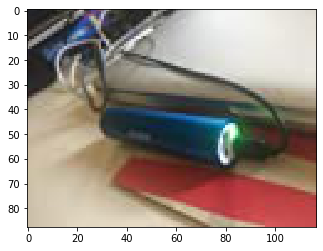

In [82]:
#Displaying product image

cellphones_image_df = cellphones_spec_df.dropna(subset=['image'])
cellphones_image_df = cellphones_image_df.reset_index()

response = requests.get(cellphones_image_df.image[2][0])
img = Image.open(BytesIO(response.content))
plt.imshow(img)

#### As we can see, the number of people who rated 5 is significantly higher than the other options, which means that most buyers are satisfied with their purchase and it probably has more positive characteristics than negative.

Text(0.5, 1.0, 'Distribution of Ratings')

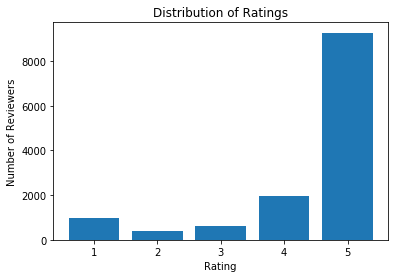

In [83]:
#Rating distribution

cellphones_spec_rating_df = cellphones_spec_df.groupby(["overall"])["asin"].count().reset_index(name="count")

x = [rate for rate in cellphones_spec_rating_df['overall']]
y = [count for count in cellphones_spec_rating_df['count']]

plt.bar(x,y)
plt.xlabel("Rating")
plt.ylabel("Number of Reviewers")
plt.title("Distribution of Ratings")

In [84]:
#Dataset containing reviews with high rate only
cellphones_spec_pos_df = cellphones_spec_df[cellphones_spec_df.overall > 3]
cellphones_spec_pos_df= cellphones_spec_pos_df.reset_index()
print(cellphones_spec_pos_df.shape[0])

11245


In [85]:
#Examples for positive reviews on the product
for i in range(14,21):
    rev=cellphones_spec_pos_df['reviewText'][i]
    print(f'review: {i}\n{rev}\n\n')

review: 14
works like a charm!


review: 15
I am changing my last review.  I played around with this some more and it works better than I originally thought.  My daughter believes her charger is just too slow.  Mine is ok for the limited amount of times I use it.  There is not a lot of charge stored so the light will turn yellow pretty quickly while it's charging.

the company did reach out to me and offered to replace the units which I think says positive things about the company.  I'm choosing to keep the two I have.

You just need to know what it's capable of and how you want to use it.


review: 16
Always the best choice amomng the power banks!


review: 17
So far so good. I keep it charged and readily available. I haven't needed it yet but carry it just in case. Light weight, cute pink color and cones in a nice little carry bag.


review: 18
Works great!  Charged my phone within an hour.  Only took an hour to recharge the device for use again.  Light and very convenient to keep wi

In [86]:
#Dataset containing reviews with low rate only
cellphones_spec_neg_df = cellphones_spec_df[cellphones_spec_df.overall < 3]
cellphones_spec_neg_df= cellphones_spec_neg_df.reset_index()
print(cellphones_spec_neg_df.shape[0])

1354


In [87]:
#Examples for negative reviews on the product
for i in range(10,17):
    rev=cellphones_spec_neg_df['reviewText'][i]
    print(f'review: {i}\n{rev}\n\n')    

review: 10
Doesn't hold a charge. Worthless when you need it the most.


review: 11
This only give you one charge. Each time I charge it up fully and use it to charge my phone just once it's dead. ThoughT I would be able to charge my phone like 2 or 3 times with it


review: 12
Didnt work at all with my iphone 6 plus. Bought two because of the wildfires going on here in Colorado and needed something for evacuations, but neither work.  Even bought the extra Anker cords for iphone in case it was something on my end. Still don't work. Super frustrating.


review: 13
Stolen off my porch


review: 14
The worse portable charger Ive ever bought. Same your money.


review: 15
ONLY CHARGES MY PHONE ONECE THEN RUNS OUT OF BATTERY


review: 16
I bought this because I constantly find myself with a phone on low battery while out and about, and I wanted a portable charger that was lightweight and would fit in a small bag or pocket. Ive been using my cars Halo battery to charge my phone on the go, wh

##### Word2Vec models

In [88]:
#read positive and negative words and their vectors

with open('Cellphones/word2vec/specific/cellphone_specific_product_word2vec_positive_words.txt',mode='r') as f:
            cellphones_spec_pos_words = json.load(f)
        
cellphones_spec_pos_vectors = np.load("Cellphones/word2vec/specific/cellphone_specific_product_word2vec_positive_vectors.npy")


with open('Cellphones/word2vec/specific/cellphone_specific_product_word2vec_negative_words.txt',mode='r') as f:
            cellphones_spec_neg_words = json.load(f)
        
cellphones_spec_neg_vectors = np.load("Cellphones/word2vec/specific/cellphone_specific_product_word2vec_negative_vectors.npy")

#### We can see that some of the words with closer meaning have closer vectors such as "charge" and "charges" or "on" and "of".

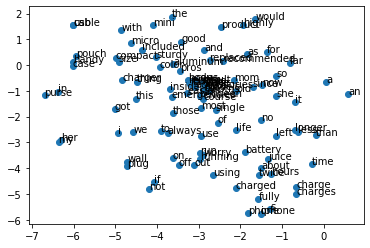

In [89]:
w2v_visualize(cellphones_spec_pos_vectors, cellphones_spec_pos_words)

#### We can see that the words are denser, it seems that there is a very close semantic relationship between the hundred chosen words.

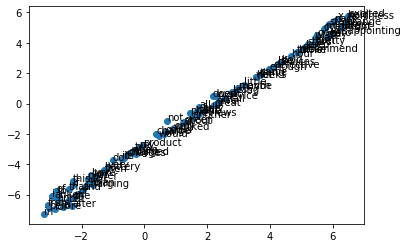

In [90]:
w2v_visualize(cellphones_spec_neg_vectors, cellphones_spec_neg_words)

##### K-means clustering

In [91]:
#Positive Cellphones k-means
cellphones_spec_pos_kmeans = KMeans(n_clusters=7, random_state=500).fit(cellphones_spec_pos_vectors)
WordsFromEachCluster(cellphones_spec_pos_words, cellphones_spec_pos_kmeans,20)

GROUP  0
this
product
replaced
mini
highly
recommended
other
by
received
was
everyone
wish
more
happy
people
mah
here
decided
again
updated



GROUP  1
i
got
mom
since
she
old
far
now
we
have
has
after
had
first
mine
working
one
each
them
family



GROUP  2
my
her
iphone
s
battery
phone
juice
time
charges
less
than
hours
fully
charged
twice
charge
left
longer
about
it



GROUP  3
for
with
of
course
life
between
those
models
a
result
the
most
length
body
thing
inside
bright
silver
easier
charger



GROUP  4
as
pros
compact
size
sturdy
aluminum
good
color
fast
also
is
job
very
high
quality
construction
useful
expected
easy
looks



GROUP  5
in
purse
usb
handy
pouch
cable
plug
case
little
small
pocket
into
around
keep
carry
bag
comes
cord
your
put



GROUP  6
an
would
run
out
always
to
using
wall
on
off
if
not
use
no
worry
running
all
will
need
being





#### We can see that the clusters are mixed, we will examine the results to see if they will be affected by it

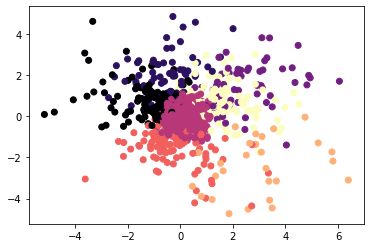

In [92]:
#Visualize Cellphones k-means positive model
kmeans_visualize(cellphones_spec_pos_kmeans, cellphones_spec_pos_vectors)

In [93]:
#Negative Cellphones k-means
cellphones_spec_neg_kmeans = KMeans(n_clusters=7, random_state=500).fit(cellphones_spec_neg_vectors)
WordsFromEachCluster(cellphones_spec_neg_words, cellphones_spec_neg_kmeans,20)

GROUP  0
this
when
do
i
is
have
charged
it
to
my
for
than
an
before
the
light
a
two
and
then



GROUP  1
orange
pack
starts
larger
ok
didnt
here
super
myself
hardly
thinking
point
might
nd
period
probably
attempted
rating
based
wife



GROUP  2
gets
recommend
stars
pretty
hour
broke
turn
turns
keep
lasted
most
thought
able
plus
going
ever
find
bag
dies
outlet



GROUP  3
worthless
held
excited
x
frustrating
runs
constantly
pocket
halo
awful
computer
im
wouldnt
supply
spent
prior
told
similar
perform
limited



GROUP  4
hot
thing
weeks
life
month
same
devices
defective
maybe
enough
hold
little
died
need
dead
needed
still
fit
been
go



GROUP  5
using
not
could
give
only
charge
phone
less
green
about
would
work
get
all
great
reviews
am
device
fully
small



GROUP  6
wish
zero
overnight
goes
disappointing
stay
minute
unfortunately
each
extra
cords
case
end
ive
low
wanted
heavy
getting
found
lasts





####  As we can see, we got a clear distinction between the clusters which would hopefully grant us better results.

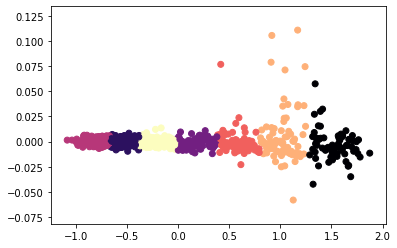

In [94]:
#Visualize Cellphones k-means negative model
kmeans_visualize(cellphones_spec_neg_kmeans, cellphones_spec_neg_vectors)

In [95]:
cellphones_max_adj_pos_group, adj_ratio_positive_group = most_adj(cellphones_spec_pos_words, cellphones_spec_pos_kmeans, adj_adv_words)
print(f'The positive group with the greatest amount of Adjectives is group number {cellphones_max_adj_pos_group}')

cellphones_words_from_specific_positive_group = AllWordsFromSpecificCluster(cellphones_spec_pos_words,cellphones_spec_pos_kmeans, cellphones_max_adj_pos_group)
print("The amount of words in this group",len(cellphones_words_from_specific_positive_group))

print(f'The ratio between the amount of adjectives we found in this group and the size of the group is {round(adj_ratio_positive_group, 2)}')

The positive group with the greatest amount of Adjectives is group number 4
The amount of words in this group 95
The ratio between the amount of adjectives we found in this group and the size of the group is 0.46


In [96]:
#printed the 10 head from Cellphones specific positive group 
cellphones_words_from_specific_positive_group[:10]

['as',
 'pros',
 'compact',
 'size',
 'sturdy',
 'aluminum',
 'good',
 'color',
 'fast',
 'also']

In [97]:
cellphones_max_adj_neg_group, adj_ratio_negative_group = most_adj(cellphones_spec_neg_words, cellphones_spec_neg_kmeans, adj_adv_words)
print(f'The negative group with the greatest amount of Adjectives is group number {cellphones_max_adj_neg_group}')

cellphones_words_from_specific_negative_group = AllWordsFromSpecificCluster(cellphones_spec_neg_words,cellphones_spec_neg_kmeans, cellphones_max_adj_neg_group)
print("The amount of words in this group",len(cellphones_words_from_specific_negative_group))

print(f'The ratio between the amount of adjectives we found in this group and the size of the group is {round(adj_ratio_negative_group, 2)}')

The negative group with the greatest amount of Adjectives is group number 4
The amount of words in this group 69
The ratio between the amount of adjectives we found in this group and the size of the group is 0.3


In [98]:
#printed the 10 head from Cellphones specific negative group 
words_from_specific_negative_group[:10]

['much',
 'small',
 'fine',
 'hot',
 'described',
 'does',
 'clear',
 'cheap',
 'different',
 'disappointed']

##### Dictionaries

In [99]:
#Loading Cellphones specific product dictionary positive files
with open('Cellphones/word2vec/specific/cellphone_specific_product_word2vec_positive_tuples_count.txt',mode='r') as pos_file:
    cellphones_spec_pos_tuples_count = json.loads(json.load(pos_file))

In [100]:
#Loading Cellphones specific product dictionary negative files 
with open('Cellphones/word2vec/specific/cellphone_specific_product_word2vec_negative_tuples_count.txt',mode='r') as neg_file:
    cellphones_spec_neg_tuples_count = json.loads(json.load(neg_file))

In [101]:
#The tuples that appear relatively more in positive reviews and negative reviews
cellphones_spec_pos_amount_reviews = cellphones_spec_pos_df.shape[0]
cellphones_spec_neg_amount_reviews = cellphones_spec_neg_df.shape[0]
cellphones_spec_top_positive, cellphones_spec_top_negative = TopList(cellphones_spec_pos_tuples_count,cellphones_spec_neg_tuples_count,cellphones_spec_pos_amount_reviews,cellphones_spec_neg_amount_reviews,20)

In [102]:
cellphones_spec_top_positive

[("('great', 'customer', 'service')", (0.00791462872387728, 0.0)),
 ("('charges', 'phone', 'fast')", (0.004357492218763895, 0.0)),
 ("('great', 'little', 'charger')", (0.00426856380613606, 0.0)),
 ("('holds', 'charge', 'long')", (0.003646064917741218, 0.0)),
 ("('works', 'like', 'charm')", (0.0033792796798577146, 0.0)),
 ("('great', 'portable', 'charger')", (0.003201422854602045, 0.0)),
 ("('great', 'product', 'great')", (0.002845709204090707, 0.0)),
 ("('highly', 'recommend', 'product')", (0.002845709204090707, 0.0)),
 ("('charger', 'works', 'great')",
  (0.002845709204090707, 0.0007385524372230429)),
 ("('excellent', 'customer', 'service')", (0.0027567807914628726, 0.0)),
 ("('compact', 'easy', 'use')", (0.0026678523788350376, 0.0)),
 ("('works', 'great', 'charges')", (0.002401067140951534, 0.0)),
 ("('love', 'anker', 'products')", (0.0022232103156958646, 0.0)),
 ("('product', 'works', 'great')", (0.0022232103156958646, 0.0)),
 ("('best', 'portable', 'charger')", (0.00213428190306803

In [103]:
cellphones_spec_top_negative

[("('not', 'hold', 'charge')", (0.0, 0.07459379615952733)),
 ("('not', 'charge', 'phone')", (0.0, 0.04431314623338257)),
 ("('not', 'charge', 'iphone')", (0.0, 0.01772525849335303)),
 ("('but', 'not', 'charge')", (0.0009782125389061805, 0.01772525849335303)),
 ("('hold', 'charge', 'long')", (0.0, 0.014032496307237814)),
 ("('not', 'work', 'iphone')", (0.0, 0.012555391432791729)),
 ("('not', 'fit', 'iphone')", (0.0, 0.012555391432791729)),
 ("('not', 'waste', 'money')", (0.0, 0.0103397341211226)),
 ("('not', 'fully', 'charge')", (0.0, 0.009601181683899557)),
 ("('not', 'stay', 'charged')", (0.0, 0.007385524372230428)),
 ("('charge', 'iphone', 's')", (0.0, 0.007385524372230428)),
 ("('fully', 'charge', 'phone')", (0.0, 0.007385524372230428)),
 ("('charge', 'not', 'charge')", (0.0, 0.0066469719350073855)),
 ("('charge', 'cell', 'phone')", (0.0, 0.0066469719350073855)),
 ("('item', 'not', 'work')", (0.0, 0.005908419497784343)),
 ("('stopped', 'holding', 'charge')", (0.0, 0.0059084194977843

#### Our concerns about the K-means diagram faded, the results that we got here are great! we can clearly understand that the product can charge the phone fast, its also portable, compact and easy to use and that the company that sells it has great customer service.

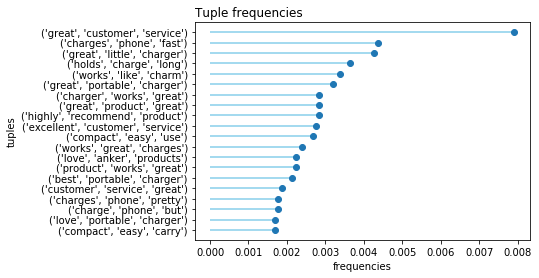

In [104]:
#Visualizing top positive Cellphones specific product
VisualizingTopTuples(0,cellphones_spec_top_positive)

#### We got here some nice results as well, we can understand that the main problem of this product is that it not work well on iPhones

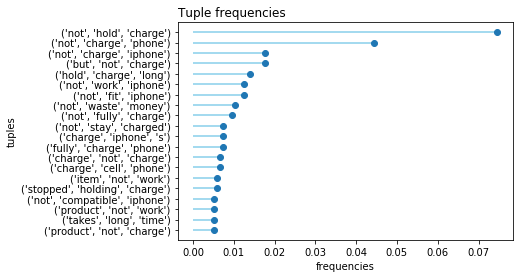

In [106]:
#Visualizing top negative Cellphones specific product
VisualizingTopTuples(1,cellphones_spec_top_negative)

#### Most top positive combinations are clearly positive and most of the top negative combinations are clearly negative.

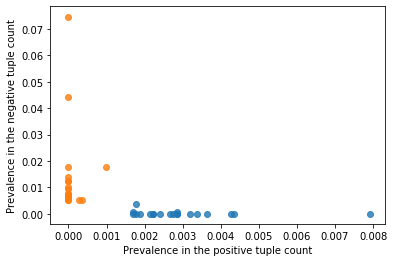

In [107]:
#Displaying the prevalence for each top 20 tuples in the negative and positive Cellphones dictionaries
VisualizingTopTuplesNegative_Positive(cellphones_spec_top_positive,cellphones_spec_top_negative)

<br>

<br>
__________________________________________________________________________________________________________________________

### Electronics

In [108]:
#Loading Electronics specific product data

electronics_spec_df = pd.read_pickle("Electronics/word2vec/specific/electronics_specific_product.pickle")
electronics_spec_df.head()

,asin,reviewText,overall,image,reviewSentences
0,B00004T8R2,I bought these to use on my computer at work a...,5.0,NaN,"[[i, bought, these, to, use, on, my, computer,..."
1,B00004T8R2,These are the best portable headphones in this...,4.0,NaN,"[[these, are, the, best, portable, headphones,..."
2,B00004T8R2,"If you want value for your money, if you lose ...",5.0,NaN,"[[if, you, want, value, for, your, money, if, ..."
3,B00004T8R2,You don't get a better headphone for five buck...,5.0,NaN,"[[you, do, not, get, a, better, headphone, for..."
4,B00004T8R2,"For such a cheap little thing, bass sounds goo...",4.0,NaN,"[[for, such, a, cheap, little, thing, bass, so..."


##### Let's take a closer look at our specific product

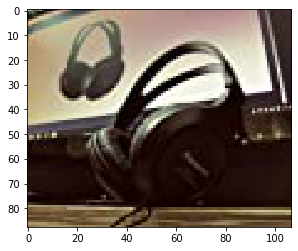

In [109]:
#Displaying product image

electronics_image_df = electronics_spec_df.dropna(subset=['image'])
electronics_image_df = electronics_image_df.reset_index()

response = requests.get(electronics_image_df.image[0][0])
img = Image.open(BytesIO(response.content))
plt.imshow(img)

#### As we can see, the number of people who rated 5 is significantly higher than the other options, which means that most buyers are satisfied with their purchase and it probably has more positive characteristics than negative.

Text(0.5, 1.0, 'Distribution of Ratings')

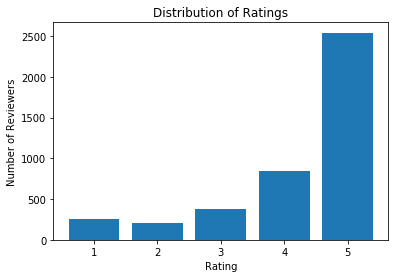

In [110]:
#Distribution of rating

electronics_spec_rating_df = electronics_spec_df.groupby(["overall"])["asin"].count().reset_index(name="count")

x = [rate for rate in electronics_spec_rating_df['overall']]
y = [count for count in electronics_spec_rating_df['count']]

plt.bar(x,y)
plt.xlabel("Rating")
plt.ylabel("Number of Reviewers")
plt.title("Distribution of Ratings")

In [111]:
#Dataset containing reviews with high rate only
electronics_spec_pos_df = electronics_spec_df[electronics_spec_df.overall > 3]
electronics_spec_pos_df= electronics_spec_pos_df.reset_index()
print(electronics_spec_pos_df.shape[0])

3382


In [112]:
#Examples for positive reviews on the product
for i in range(12,19):
    rev=electronics_spec_pos_df['reviewText'][i]
    print(f'review: {i}\n{rev}\n\n')

review: 12
For the price, these are absolutely phenomenal.  The sound quality is pretty much as good as I really need for enjoying music, and I usually consider myself *fairly* picky about that.  They do leak very badly though, if that's a concern for you (i.e. others may hear your music if it's very loud).
They do get a bit uncomfortable if you wear them for over a couple hours, because they put a bit of pressure on the ear; but maybe that's just me.
My one complaint is that recently the adjustable notches on the right side went loose on mine, so it slides up and down when I take them off; but they still stay in place just fine when I'm wearing them.  But I've had these for almost two years before that happened, using them almost every day.


review: 13
Of course is not the best, but in the price-quality ratio it probably is.


review: 14
These headphones sound awesome!


review: 15
I hate in-ear headphones. These are a nice, cheap over ear set. Hard to find.


review: 16
I love these

In [113]:
#Dataset containing reviews with low rate only
electronics_spec_neg_df = electronics_spec_df[electronics_spec_df.overall < 3]
electronics_spec_neg_df= electronics_spec_neg_df.reset_index()
print(electronics_spec_neg_df.shape[0])

455


In [114]:
#Examples for negative reviews on the product
for i in range(20,26):
    rev=electronics_spec_neg_df['reviewText'][i]
    print(f'review: {i}\n{rev}\n\n')

review: 20
Not good for working out they fall off.


review: 21
Hard and uncomfortable, returned.  The sound was as expected for the price, would have kept if it wasn't uncomfortable.


review: 22
I liked them a lot until at the six month point the wire near the right headphone became defective.  I could wiggle it to get sound through that side for a few days but now I hear nothing through the right side.  I wore them at my desk at my 9-5 job - there was no real wear and tear on them.  I'm rather disappointed that they only lasted six months.  I've worn this type of headphones for 40 years, back to being a paperboy, and I've never had them wear out nearly this fast.  It was almost always the headphone pads that would wear out first, after 3-5 years.


review: 23
When I purchased these headphones, I thought I'd have a cheap pair of headphones to use at bedtime when listening to music. Surprise, surprise, surprise, they don't fit the 3.5mm port on my Samsung phone!


review: 24
Fit good.

##### Word2Vec models

In [115]:
#read positive and negative words and their vectors

with open('Electronics/word2vec/specific/electronics_specific_product_word2vec_positive_words.txt',mode='r') as f:
            electronics_spec_pos_words = json.load(f)
        
electronics_spec_pos_vectors = np.load("Electronics/word2vec/specific/electronics_specific_product_word2vec_positive_vectors.npy")


with open('Electronics/word2vec/specific/electronics_specific_product_word2vec_negative_words.txt',mode='r') as f:
            electronics_spec_neg_words = json.load(f)
        
electronics_spec_neg_vectors = np.load("Electronics/word2vec/specific/electronics_specific_product_word2vec_negative_vectors.npy")

#### We can see that some of the words with closer meaning have closer vectors such as "more" and "much" or "this" and "these"

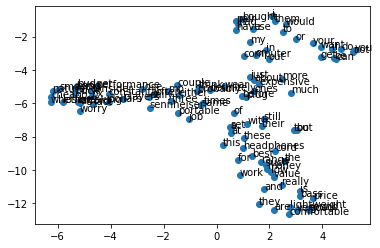

In [116]:
w2v_visualize(electronics_spec_pos_vectors, electronics_spec_pos_words)

#### It seems that there is a very close semantic relationship between the hundred chosen words.

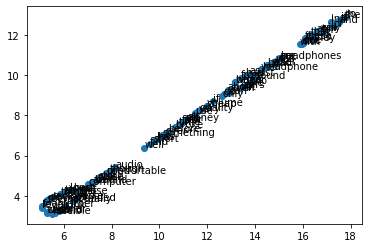

In [117]:
w2v_visualize(electronics_spec_neg_vectors, electronics_spec_neg_words)

##### K-means clustering

In [118]:
#Positive Electronics specific product k-means
electronics_spec_pos_kmeans = KMeans(n_clusters=7, random_state=500).fit(electronics_spec_pos_vectors)
WordsFromEachCluster(electronics_spec_pos_words,electronics_spec_pos_kmeans,20)

GROUP  0
cheapo
smooth
natural
losing
whether
accurate
opinion
wore
general
heck
sat
anybody
thanks
enjoying
picky
ie
notches
ratio
listed
known



GROUP  1
computer
think
with
a
before
much
more
expensive
set
of
just
about
same
probably
times
definitely
ones
wear
plug
was



GROUP  2
portable
three
sennheiser
lose
often
couple
mp
players
daily
either
cheaper
absolutely
came
deep
rich
once
deal
least
give
five



GROUP  3
these
at
work
the
job
such
low
but
headphones
their
best
this
range
still
for
value
money
too
cord
phones



GROUP  4
and
they
are
lightweight
very
comfortable
price
really
is
good
bass
sound
excellent
great
quality
clear
inexpensive
nice
fit
pretty



GROUP  5
performance
fact
bang
buck
afford
consider
px
dollars
budget
worry
breaking
constantly
update
done
original
basic
per
strong
advertised
s



GROUP  6
i
bought
to
use
on
my
do
you
would
be
not
had
in
if
can
or
want
pair
get
your





####  As we can see, we got a clear distinction between the clusters.

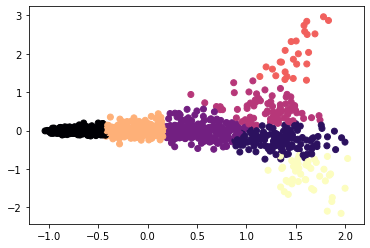

In [119]:
#Visualize Electronics specific product k-means positive model
kmeans_visualize(electronics_spec_pos_kmeans, electronics_spec_pos_vectors)

In [120]:
#Negative Electronics specific product k-means
electronics_spec_neg_kmeans = KMeans(n_clusters=7, random_state=500).fit(electronics_spec_neg_vectors)
WordsFromEachCluster(electronics_spec_neg_words, electronics_spec_neg_kmeans,20)

GROUP  0
used
week
still
half
around
noise
computer
audio
though
comfortable
pay
set
makes
plastic
may
size
go
less
bad
went



GROUP  1
do
had
when
up
volume
sound
only
two
quality
very
if
better
from
as
even
use
ears
like
cheap
just



GROUP  2
junk
waste
thing
put
sounded
either
loud
best
actually
almost
tinny
those
anything
dead
why
guess
tight
tried
being
snapped



GROUP  3
broke
time
money
short
first
low
before
all
off
well
something
pair
over
find
has
what
hear
good
price
fit



GROUP  4
the
i
it
a
and
my
will
in
at
of
to
for
them

No More Words In This Group



GROUP  5
not
your
this
headphone
after
was
one
on
that
headphones
you
with
these
are
they
is
ear
head
so
but



GROUP  6
second
received
level
devices
ever
horrible
move
dollar
seems
weak
foam
always
said
course
length
hold
overall
kept
things
yet





####  As we can see here as well, we got a clear distinction between the clusters.<br>It seems like when we test the model on a specific product we get better clusters, maybe because there are no conflicts with reviews of different products.

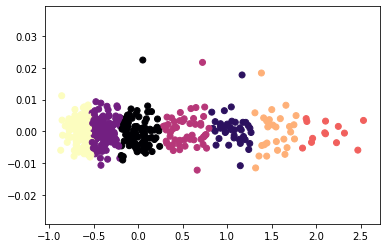

In [121]:
#Visualize Electronics specific product k-means negative model
kmeans_visualize(electronics_spec_neg_kmeans, electronics_spec_neg_vectors)

In [122]:
electronics_max_adj_pos_group, adj_ratio_positive_group = most_adj(electronics_spec_pos_words, electronics_spec_pos_kmeans, adj_adv_words)
print(f'The positive group with the greatest amount of Adjectives is group number {electronics_max_adj_pos_group}')

electronics_words_from_specific_positive_group = AllWordsFromSpecificCluster(electronics_spec_pos_words,electronics_spec_pos_kmeans, electronics_max_adj_pos_group)
print("The amount of words in this group",len(electronics_words_from_specific_positive_group))

print(f'The ratio between the amount of adjectives we found in this group and the size of the group is {round(adj_ratio_positive_group, 2)}')

The positive group with the greatest amount of Adjectives is group number 4
The amount of words in this group 26
The ratio between the amount of adjectives we found in this group and the size of the group is 0.42


In [123]:
#printed the 10 head from Electronics specific product positive group 
electronics_words_from_specific_positive_group[:10]

['and',
 'they',
 'are',
 'lightweight',
 'very',
 'comfortable',
 'price',
 'really',
 'is',
 'good']

In [124]:
electronics_max_adj_neg_group, adj_ratio_negative_group = most_adj(electronics_spec_neg_words, electronics_spec_neg_kmeans, adj_adv_words)
print(f'The negative group with the greatest amount of Adjectives is group number {electronics_max_adj_neg_group}')

electronics_words_from_specific_negative_group = AllWordsFromSpecificCluster(electronics_spec_neg_words,electronics_spec_neg_kmeans, electronics_max_adj_neg_group)
print("The amount of words in this group",len(electronics_words_from_specific_negative_group))

print(f'The ratio between the amount of adjectives we found in this group and the size of the group is {round(adj_ratio_negative_group, 2)}')

The negative group with the greatest amount of Adjectives is group number 3
The amount of words in this group 52
The ratio between the amount of adjectives we found in this group and the size of the group is 0.29


In [125]:
#printed the 10 head from Electronics specific product negative group 
electronics_words_from_specific_negative_group[:10]

['broke',
 'time',
 'money',
 'short',
 'first',
 'low',
 'before',
 'all',
 'off',
 'well']

##### Dictionaries

In [126]:
#Loading Electronics specific product dictionary positive files
with open('Electronics/word2vec/specific/electronics_specific_product_word2vec_positive_tuples_count.txt',mode='r') as pos_file:
    electronics_spec_pos_tuples_count = json.loads(json.load(pos_file))

In [127]:
#Loading Electronics specific product dictionary negative files 
with open('Electronics/word2vec/specific/electronics_specific_product_word2vec_negative_tuples_count.txt',mode='r') as neg_file:
    electronics_spec_neg_tuples_count = json.loads(json.load(neg_file))

In [128]:
#The tuples that appear relatively more in positive reviews and negative
electronics_spec_pos_amount_reviews= electronics_spec_pos_df.shape[0]
electronics_spec_neg_amount_reviews= electronics_spec_neg_df.shape[0]
electronics_spec_top_positive, electronics_spec_top_negative = TopList(electronics_spec_pos_tuples_count,electronics_spec_neg_tuples_count,electronics_spec_pos_amount_reviews,electronics_spec_neg_amount_reviews,20)

In [129]:
electronics_spec_top_positive

[("('good', 'sound', 'quality')", (0.01744529863985807, 0.002197802197802198)),
 ("('sound', 'quality', 'good')",
  (0.014192785334121822, 0.002197802197802198)),
 ("('not', 'beat', 'price')", (0.011827321111768185, 0.0)),
 ("('great', 'sound', 'quality')",
  (0.006800709639266706, 0.002197802197802198)),
 ("('good', 'sound', 'price')", (0.0056179775280898875, 0.002197802197802198)),
 ("('rpht', 'lightweight', 'headphones')", (0.005322294500295683, 0.0)),
 ("('sound', 'quality', 'great')", (0.005322294500295683, 0.0)),
 ("('sound', 'great', 'price')", (0.005026611472501478, 0.0)),
 ("('headphone', 'sound', 'good')", (0.004435245416913069, 0.0)),
 ("('sound', 'quality', 'excellent')", (0.004435245416913069, 0.0)),
 ("('panasonic', 'rpht', 'lightweight')",
  (0.004139562389118865, 0.002197802197802198)),
 ("('good', 'headphones', 'price')", (0.004139562389118865, 0.0)),
 ("('decent', 'sound', 'quality')", (0.004139562389118865, 0.0)),
 ("('sound', 'good', 'price')", (0.00384387936132466,

In [130]:
electronics_spec_top_negative

[("('not', 'waste', 'money')", (0.0, 0.01098901098901099)),
 ("('not', 'good', 'sound')", (0.0005913660555884093, 0.008791208791208791)),
 ("('but', 'not', 'worth')", (0.0, 0.006593406593406593)),
 ("('low', 'price', 'not')", (0.0008870490833826139, 0.006593406593406593)),
 ("('not', 'fit', 'properly')", (0.0, 0.006593406593406593)),
 ("('headphone', 'not', 'fit')",
  (0.00029568302779420464, 0.006593406593406593)),
 ("('not', 'worth', 'return')", (0.0, 0.006593406593406593)),
 ("('sound', 'not', 'great')", (0.0005913660555884093, 0.004395604395604396)),
 ("('ear', 'piece', 'break')", (0.0, 0.004395604395604396)),
 ("('not', 'recommend', 'product')", (0.0, 0.004395604395604396)),
 ("('increase', 'bass', 'response')", (0.0, 0.004395604395604396)),
 ("('not', 'worth', 'postage')", (0.0, 0.004395604395604396)),
 ("('total', 'waste', 'money')", (0.0, 0.004395604395604396)),
 ("('not', 'hear', 'thing')", (0.0, 0.004395604395604396)),
 ("('tinny', 'no', 'bass')", (0.0, 0.004395604395604396))

#### We got some really good results, we can assume that the product has good sound quality and it is also lightweight and comfortable.

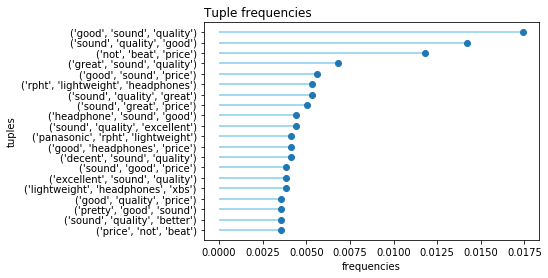

In [131]:
#Visualizing top positive Electronics specific product
VisualizingTopTuples(0,electronics_spec_top_positive)

#### This result indicates that there is some controversy about the sound quality of the product. Besides, some who have argued that the small size of the product disturbed and did not fit them.

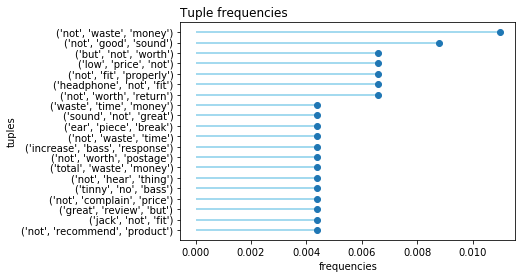

In [132]:
#Visualizing top negative Electronics specific product
VisualizingTopTuples(1,electronics_spec_top_negative)

#### We can see that there's an overlap between the positive combinations and the negative combinations.

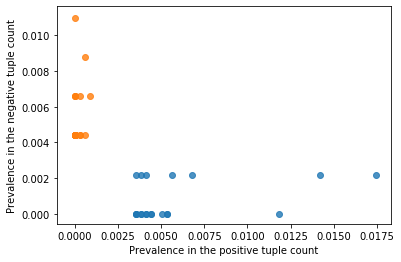

In [133]:
#Displaying the prevalence for each top 20 tuples in the negative and positive Electronics dictionaries
VisualizingTopTuplesNegative_Positive(electronics_spec_top_positive,electronics_spec_top_negative)

<br>

<br>
__________________________________________________________________________________________________________________________

### Automotive

In [134]:
#Loading Automotive specific product data
import pandas as pd 
automotive_spec_df = pd.read_pickle("Automotive/word2vec/specific/automotive_specific_product.pickle")
automotive_spec_df.head()

,asin,reviewText,overall,image,reviewSentences
0,B0000AY3X0,This thing is superior to any chamois I have e...,5.0,NaN,"[[this, thing, is, superior, to, any, chamois,..."
1,B0000AY3X0,No more wet dog towels to dry. Its curious ho...,5.0,NaN,"[[no, more, wet, dog, towels, to, dry], [its, ..."
2,B0000AY3X0,I wash my vehicle's a lot and used to buy a ne...,5.0,NaN,"[[i, wash, my, vehicles, a, lot, and, used, to..."
3,B0000AY3X0,At my job we transport all levels of VIP and t...,5.0,NaN,"[[at, my, job, we, transport, all, levels, of,..."
4,B0000AY3X0,This chamois worked very well in comparison to...,4.0,NaN,"[[this, chamois, worked, very, well, in, compa..."


##### Let's take a closer look at our specific product

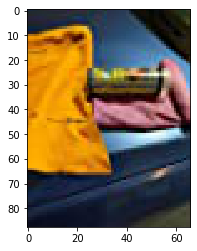

In [135]:
#Displaying product image

automotive_image_df = automotive_spec_df.dropna(subset=['image'])
automotive_image_df = automotive_image_df.reset_index()

response = requests.get(automotive_image_df.image[0][0])
img = Image.open(BytesIO(response.content))
plt.imshow(img)

#### As we can see, the number of people who rated 5 is significantly higher than the other options, which means that most buyers are satisfied with their purchase and it probably has more positive characteristics than negative.

Text(0.5, 1.0, 'Distribution of Ratings')

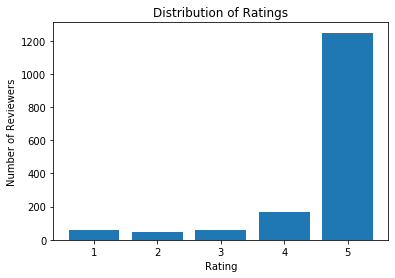

In [136]:
#Distribution of rating

automotive_spec_rating_df = automotive_spec_df.groupby(["overall"])["asin"].count().reset_index(name="count")

x = [rate for rate in automotive_spec_rating_df['overall']]
y = [count for count in automotive_spec_rating_df['count']]

plt.bar(x,y)
plt.xlabel("Rating")
plt.ylabel("Number of Reviewers")
plt.title("Distribution of Ratings")

In [137]:
#Dataset containing reviews with high rate only
automotive_spec_pos_df = automotive_spec_df[automotive_spec_df.overall > 3]
automotive_spec_pos_df= automotive_spec_pos_df.reset_index()
print(automotive_spec_pos_df.shape[0])

1416


In [138]:
#Examples for positive reviews on the product
for i in range(6,12):
    rev=automotive_spec_pos_df['reviewText'][i]
    print(f'review: {i}\n{rev}\n\n')

review: 6
We have had one of these for YEARS (10+) & it still works great!

Cleans the car with no streaks.

Just roll up & store (damp) in container.


review: 7
Every Year my Brother asks for an Absorber for Christmas.  He swears by it and it lasts all yearlong!


review: 8
These will dry your car with no streaks and you can use it over and over and throw it in the washer. Best of all you can wring it as you dry your car so it becomes bone dry again. Great for windows where streaks usually show up, but not after "the absorber."


review: 9
My husband has been using the same towel for a year now, he loves it. Works well to dry the truck after a car wash and doesnt leave streaks.


review: 10
I cut this in 1/2 to use on my car. It soaks up TONS of water. What I don't understand dis why these companies don't make this in a bath towel size. Ladies with long hair love them, and they just aren't big enough for hair. When I first got it I used it after a shower to see if it really absorbed 

In [139]:
#Dataset containing reviews with low rate only
automotive_spec_neg_df = automotive_spec_df[automotive_spec_df.overall < 3]
automotive_spec_neg_df = automotive_spec_neg_df.reset_index()
print(automotive_spec_neg_df.shape[0])

104


In [140]:
#Examples for negative reviews on the product
for i in range(0,6):
    rev=automotive_spec_neg_df['reviewText'][i]
    print(f'review: {i}\n{rev}\n\n')

review: 0
Not impressed - stiff, drags across car instead of sliding, not really that absorbent. I have an older artificial chamois that is infinitely better.


review: 1
Not sure why, but it didn't dry well.


review: 2
Too small for a whole car. And I don't know how to store it. If you keep it dry, it will become hard and easy to break. If you keep it wet it will not do the work.


review: 3
Don't know about anyone else's experience but the absorber didn't work as advertised. After washing my truck, I attempted to dry it with the absorber and it did not pick up all of the water. It just smeared it. I used it as described, to rinse it in warm water before first use. I'm not at all happy with this product. This was my 2nd time using it.


review: 4
Came wet, and became hard after one day


review: 5
Brand new opened package and it had mold on it




##### Word2Vec models

In [141]:
#read positive and negative words and their vectors

with open('Automotive/word2vec/specific/automotive_specific_product_word2vec_positive_words.txt',mode='r') as f:
            automotive_spec_pos_words = json.load(f)
        
automotive_spec_pos_vectors = np.load("Automotive/word2vec/specific/automotive_specific_product_word2vec_positive_vectors.npy")


with open('Automotive/word2vec/specific/automotive_specific_product_word2vec_negative_words.txt',mode='r') as f:
            automotive_spec_neg_words = json.load(f)
        
automotive_spec_neg_vectors = np.load("Automotive/word2vec/specific/automotive_specific_product_word2vec_negative_vectors.npy")

#### For both visualizations below, it seems that there is a very close semantic relationship between the hundred chosen words.

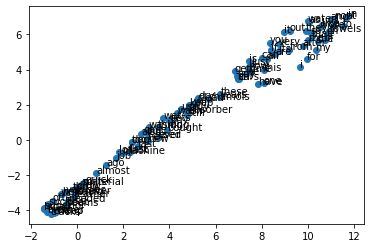

In [142]:
w2v_visualize(automotive_spec_pos_vectors, automotive_spec_pos_words)

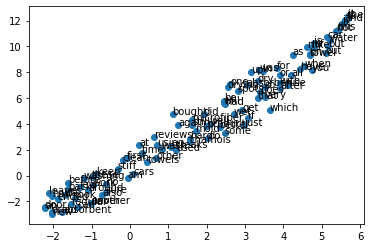

In [143]:
w2v_visualize(automotive_spec_neg_vectors, automotive_spec_neg_words)

##### K-means clustering

In [144]:
#Positive Automotive k-means
automotive_spec_pos_kmeans = KMeans(n_clusters=7, random_state=500).fit(automotive_spec_pos_vectors)
WordsFromEachCluster(automotive_spec_pos_words,automotive_spec_pos_kmeans,20)

GROUP  0
thing
chamois
ever
used
use
dry
washing
will
buy
wet
dog
fast
only
absorber
once
wash
new
he
bought
years



GROUP  1
suck
often
top
however
wrung
especially
show
dust
cleans
lasts
washer
where
usually
loves
working
wanted
accidentally
fold
drys
rather



GROUP  2
quick
material
spills
throw
dirty
tried
reviews
husband
washes
year
windows
same
cut
why
bath
enough
awesome
let
know
else



GROUP  3
superior
cheap
local
trucks
brother
gifts
comparison
expecting
classic
christmas
doesnt
understand
absorbed
clear
stamp
section
doors
finished
showers
window



GROUP  4
this
is
to
any
i
have
it
my
cars
after
and
so
very
one
no
more
towels
its
how
out



GROUP  5
forever
seems
wringing
vehicles
leather
needed
boat
help
worked
bit
read
lasting
bad
auto
roll
becomes
truck
soaks
see
money



GROUP  6
last
job
lot
ago
first
almost
machine
make
something
long
left
spots
paint
microfiber
uses
his
size
hair
love
big





#### As we can see, we got a clear distinction between the clusters.

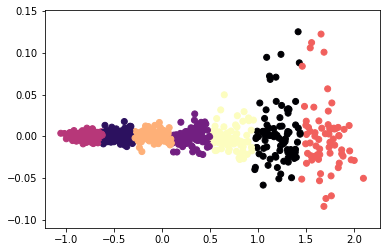

In [145]:
#Visualize Automotive k-means positive model
kmeans_visualize(automotive_spec_pos_kmeans, automotive_spec_pos_vectors)

In [146]:
#Negative Automotive k-means
automotive_spec_neg_kmeans = KMeans(n_clusters=7, random_state=500).fit(automotive_spec_neg_vectors)
WordsFromEachCluster(automotive_spec_neg_words, automotive_spec_neg_kmeans,20)

GROUP  0
car
of
is
but
as
my
water
on
out
towel
like

No More Words In This Group



GROUP  1
stiff
sure
keep
work
washing
before
first
am
clean
towels
few
also
back
cars
around
these
no
finish
soft
your



GROUP  2
that
have
dry
for
you
will
absorber
after
with
up
all
in
use
was
one
had
get
so
when
very



GROUP  3
it
and
to
the

No More Words In This Group



GROUP  4
chamois
better
did
well
do
if
hard
wet
just
used
at
product
time
using
mold
again
microfiber
wash
some
reviews



GROUP  5
absorbent
an
how
new
can
never
leaves
its
door
took
regular
ended
another
dried
feels
rag
find
yes
there
give



GROUP  6
not
i
a
this

No More Words In This Group





#### As we can see here as well, although it is not dense, we got a clear distinction between the clusters.

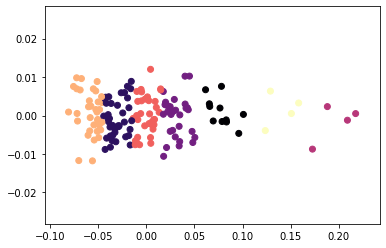

In [147]:
#Visualize Automotive k-means negative model
kmeans_visualize(automotive_spec_neg_kmeans, automotive_spec_neg_vectors)

In [148]:
automotive_max_adj_pos_group, adj_ratio_positive_group = most_adj(automotive_spec_pos_words, automotive_spec_pos_kmeans, adj_adv_words)
print(f'The positive group with the greatest amount of Adjectives is group number {automotive_max_adj_pos_group}')

automotive_words_from_specific_positive_group = AllWordsFromSpecificCluster(automotive_spec_pos_words,automotive_spec_pos_kmeans, automotive_max_adj_pos_group)
print("The amount of words in this group",len(automotive_words_from_specific_positive_group))

print(f'The ratio between the amount of adjectives we found in this group and the size of the group is {round(adj_ratio_positive_group, 2)}')

The positive group with the greatest amount of Adjectives is group number 2
The amount of words in this group 92
The ratio between the amount of adjectives we found in this group and the size of the group is 0.33


In [149]:
#printed the 10 head from Automotive specific positive group 
automotive_words_from_specific_positive_group[:10]

['quick',
 'material',
 'spills',
 'throw',
 'dirty',
 'tried',
 'reviews',
 'husband',
 'washes',
 'year']

In [150]:
automotive_max_adj_neg_group, adj_ratio_negative_group = most_adj(automotive_spec_neg_words, automotive_spec_neg_kmeans, adj_adv_words)
print(f'The negative group with the greatest amount of Adjectives is group number {automotive_max_adj_neg_group}')

automotive_words_from_specific_negative_group = AllWordsFromSpecificCluster(automotive_spec_neg_words,automotive_spec_neg_kmeans, automotive_max_adj_neg_group)
print("The amount of words in this group",len(automotive_words_from_specific_negative_group))

print(f'The ratio between the amount of adjectives we found in this group and the size of the group is {round(adj_ratio_negative_group, 2)}')

The negative group with the greatest amount of Adjectives is group number 1
The amount of words in this group 39
The ratio between the amount of adjectives we found in this group and the size of the group is 0.28


In [151]:
#printed the 10 head from Automotive specific negative group 
automotive_words_from_specific_negative_group[:10]

['stiff',
 'sure',
 'keep',
 'work',
 'washing',
 'before',
 'first',
 'am',
 'clean',
 'towels']

##### Dictionaries

In [152]:
#Loading Automotive specific product dictionary positive files
with open('Automotive/word2vec/specific/automotive_specific_product_word2vec_positive_tuples_count.txt',mode='r') as pos_file:
    automotive_spec_pos_tuples_count = json.loads(json.load(pos_file))

In [153]:
#Loading Automotive specific product dictionary negative files 
with open('Automotive/word2vec/specific/automotive_specific_product_word2vec_negative_tuples_count.txt',mode='r') as neg_file:
    automotive_spec_neg_tuples_count = json.loads(json.load(neg_file))

In [154]:
#The tuples that appear relatively more in positive reviews and negative reviews
automotive_spec_pos_amount_reviews = automotive_spec_pos_df.shape[0]
automotive_spec_neg_amount_reviews = automotive_spec_neg_df.shape[0]
automotive_spec_top_positive, automotive_spec_top_negative = TopList(automotive_spec_pos_tuples_count,automotive_spec_neg_tuples_count,automotive_spec_pos_amount_reviews,automotive_spec_neg_amount_reviews,20)

In [155]:
automotive_spec_top_positive

[("('holds', 'lot', 'water')", (0.007768361581920904, 0.0)),
 ("('better', 'natural', 'chamois')", (0.005649717514124294, 0.0)),
 ("('not', 'use', 'else')", (0.0035310734463276836, 0.0)),
 ("('works', 'better', 'natural')", (0.0035310734463276836, 0.0)),
 ("('throw', 'washing', 'machine')",
  (0.0035310734463276836, 0.009615384615384616)),
 ("('highly', 'recommend', 'product')", (0.002824858757062147, 0.0)),
 ("('like', 'natural', 'chamois')", (0.002824858757062147, 0.0)),
 ("('highly', 'recommend', 'chamois')", (0.002824858757062147, 0.0)),
 ("('cut', 'half', 'use')", (0.002824858757062147, 0.0)),
 ("('dry', 'off', 'dogs')", (0.002824858757062147, 0.0)),
 ("('no', 'water', 'marks')", (0.002824858757062147, 0.0)),
 ("('large', 'amounts', 'water')", (0.00211864406779661, 0.0)),
 ("('clean', 'rubber', 'stamps')", (0.00211864406779661, 0.0)),
 ("('use', 'car', 'washes')", (0.00211864406779661, 0.0)),
 ("('soak', 'warm', 'water')", (0.00211864406779661, 0.0)),
 ("('works', 'pretty', 'good'

In [156]:
automotive_spec_top_negative

[("('not', 'dry', 'cars')", (0.0, 0.019230769230769232)),
 ("('water', 'off', 'car')", (0.0, 0.019230769230769232)),
 ("('job', 'absorbing', 'water')",
  (0.0007062146892655367, 0.019230769230769232)),
 ("('doesnt', 'work', 'advertise')", (0.0, 0.009615384615384616)),
 ("('streaks', 'water', 'finish')", (0.0, 0.009615384615384616)),
 ("('great', 'times', 'but')", (0.0, 0.009615384615384616)),
 ("('specifically', 'clean', 'interior')", (0.0, 0.009615384615384616)),
 ("('but', 'washing', 'machine')", (0.0, 0.009615384615384616)),
 ("('purchased', 'carrand', 'microfiber')", (0.0, 0.009615384615384616)),
 ("('absorb', 'water', 'off')", (0.0, 0.009615384615384616)),
 ("('not', 'sure', 'not')", (0.0, 0.009615384615384616)),
 ("('stiff', 'board', 'moping')", (0.0, 0.009615384615384616)),
 ("('clean', 'enthusasism', 'bought')", (0.0, 0.009615384615384616)),
 ("('got', 'tube', 'little')", (0.0, 0.009615384615384616)),
 ("('best', 'buy', 'time')", (0.0, 0.009615384615384616)),
 ("('microfiber', 

#### We can understand that the product can hold a lot of water, it doesn't leave marks on the car and it can be easily cleaned using a washing machine.

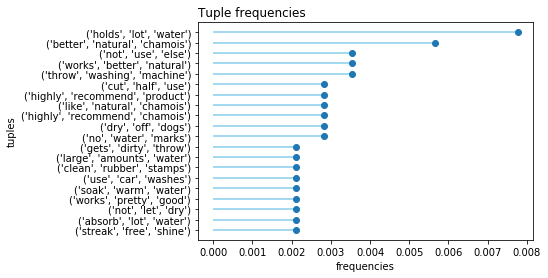

In [157]:
#Visualizing top positive Automotive specific product
VisualizingTopTuples(0,automotive_spec_top_positive)

#### We can understand that the product does not dry cars well and we can also see that some of the results we got are actually positive, such as ('great', 'substitute', 'real')

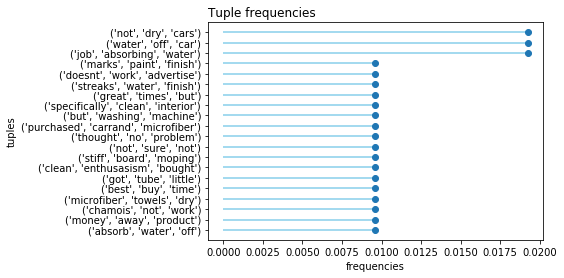

In [159]:
#Visualizing top negative Automotive specific product
VisualizingTopTuples(1,automotive_spec_top_negative)

#### We can see that there's an overlap between some of the positive combinations and negative combinations.

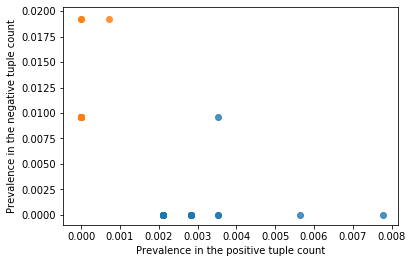

In [160]:
#Displaying the prevalence for each top 20 tuples in the negative and positive Automotive dictionaries
VisualizingTopTuplesNegative_Positive(automotive_spec_top_positive,automotive_spec_top_negative)

<br>
___________________________________________________________________________________________________________________________
<br>

## Word2Vec Conclusions

#### We expected that when the k-means diagram is unclear, then the results will be of lower quality, but this is not what necessarily happened.

#### We invested time learning Word2Vec and returned back and forth to the cleaning stage until we learned that to get better results the input of Word2Vec should be close to the original as possible.<br>Moreover, we realized that the way the sentences are split affects the results

#### We tried running the entire dataset for a single Word2Vec model.<br> We ran K-means on vectors matching the words in the entire dataset. <br>And we split into positive and negative reviews only at the stage of extracting the combinations. <br>The results were less good.

#### In our opinion, the use of the Automotive data set wasn't good as the use of the Cellphones and Electronics data sets.<br>We estimate that it does not fit this model, and we will test it based on the results of spacy.



___________________________________________________________________________________________________________________________
<br>